### Rebecq, H., Gallego, G., Mueggler, E., and Scaramuzza, D. (2017). EMVS: Event-Based Multi-View Stereo—3D Reconstruction with an Event Camera in Real-Time. International Journal of Computer Vision 1–21.

This notebook is an implementation of the above paper on semi-dense 3D reconstruction of a scene using back projection methods. The scene data is captured using an event camera. 

In [5]:
import cv2
import os
import scipy
import numpy as np
import matplotlib.pyplot as plt
import time
import pyquaternion as qt
%matplotlib notebook
data_path = 'data/slider_depth'

## Table of Contents
[1. Scene Video(optional)](#scene_video)

[2. Data Available and Data format](#data)
    
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1 Camera Matrix](#cam_mat)
   
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2 Obtaining pose information relevant to events under consideration from the groundtruth files](#event_data)
 
[3. Stages of Reconstruction](#stages)

   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1 Back-Projection](#stage_1)
   
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2 Ray-Counting](#stage_2)
   
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.3 Voting](#stage_3)
   
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.4 Scene Restructuring](#stage_4)
   
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.5 Cleaning](#stage_5)
   
    
[4. Algorithm](#algorithm)

   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.1 Pictorial Representation of the Algorithm](#algo_pic)

[5. The Main Function](#main)

<a id="scene_video"></a>
## 1. Scene Video


The DAVIS camera has a conventional image capturing system along with the event based system. While we shall not be using the conventional stream during our implementation, the conventional stream of data helps the user visualize the scene that is undergoing reconstruction.

In [2]:
normal_img_path = data_path + '/images'
normal_imgs = [normal_img_path + "/" + img for img in os.listdir(normal_img_path) if img.endswith(".png")]
normal_imgs.sort()

<IPython.core.display.Javascript object>


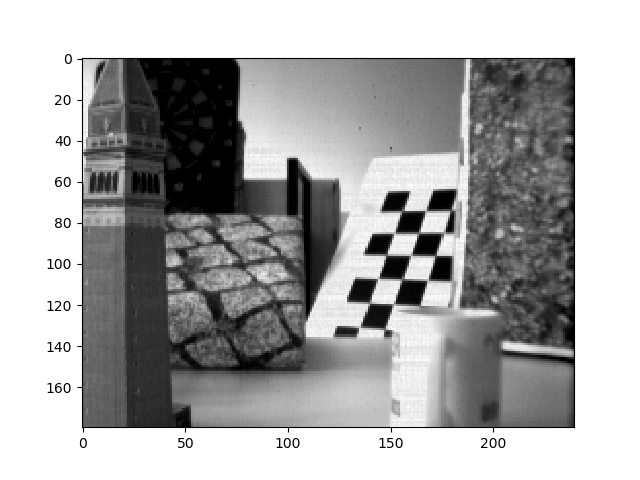

In [6]:
#### optional code snippet, Run this part if you wish to visualise the data as a video. The below sequence makes use
#### of conventional images frames and is not used anywhere else later in the notebook
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.canvas.draw()
ax.axis()
for image in normal_imgs:
    ax.clear()
    ax.imshow(plt.imread(image), cmap='gray')
    fig.canvas.draw()

<a id="data"></a>
## 2. Data Available and Data format


There are various kinds of data which we would have to work with namely, event data, imu data, calibration parameters, and ground truth data. There is also an 'images.txt' file which gives the timestamps at which synchronous event stream was captured. The format of the data are as shown below. 

![description of dataset format](Images/data_format_emvs.png)

<a id="cam_mat"></a>
### 2.1 Camera Matrix

Every camera has a calibration matrix which is dependant on the intrinsic and extrinsic parameters being used. We obtain these parameters from the <i>calib.txt</i> file.

In [7]:
def return_camera_matrix(filename='calib.txt'):
    '''
    Returns the camera matrix for the given dataset based on calibration parameters.
    
    Parameters:
    -----------
    filename : <string>
        name of the text file where the camera parameters are stored
    
    Return:
    -------
    camera_mat: <np.array>
        The camera matrix for the parameters mentioned in the calibration file
    '''
    
    file = open(data_path +'/' + filename, "r")
    cam_par = list(map(float,file.readline().split()))
    file.close()
    fx, fy, cx, cy, k1, k2, p1, p2, k3 = [par for par in cam_par]
    camera_mat = np.array([[fx,  0, cx],
                           [ 0, fy, cy],
                           [ 0,  0,  1]])
    return camera_mat, [k1, k2, p1, p2, k3]

In [8]:
def return_undistorted_coordinates(dist_cam_cords, distortion_params):
    '''
    Utility under consideration
    '''
    k1, k2, p1, p2, k3 = distortion_params
    
    pass

In [9]:
cam_mat, dist_params = return_camera_matrix()

<a id="event_data"></a>
### 2.2 Obtaining pose information relevant to events under consideration from the groundtruth files


The objective is to get an event and its corresponding pose for that particular time stamp. Since the number of events are huge and the homographies are expensive to compute, a batch of 256 events is assigned the same pose information. 

In [10]:
from itertools import islice
def bundle_events(batch_number, filename='events.txt', batch_size = 256):
    ''' 
    Return a batch of events from the file containing event information. Sometimes the event file can run into several 
    Gigabytes of storage. This is why a file is opened and closed everytime a batch of events needs to be read.
    
    Parameters:
    -----------
    batch_number : <int>
        The nth batch which needs to be read
    filename : <string>
    '''
    events=[]
    file = open(data_path +'/' + filename, "r")
    head = list(islice(file, batch_number * batch_size, (batch_number + 1)*batch_size))
    #return timestamp of first event in the batch
    event_start_time = list(map(float,head[0].split()))[0] 
    for line in head:
        events.append(list(map(float,line.split())))
    file.close()
    return events, event_start_time

In [11]:
events, event_start_time = bundle_events(batch_number=40)
print(event_start_time)

0.048514001


The pose is sampled at frequencies lower than the event data. In order to capture pose information for an event at some timestamp, it is thus necessary to linearly interpolate the pose data for that timestamp. As the trajectory is continuous and the sampling time is very small, we can assume the path between two timesteps to be fairly linear.

In [12]:
def get_ground_truth_pose(event_start_time, filename='groundtruth.txt'):
    
    ''' 
    This function returns the the groundtruth pose for an event depending on the timestamp 
    of the input given as input to the function. If pose of the event is linearly interpolated 
    if the timestamp of the event given falls in between the timestamps of the poses of the two 
    events
    
    Parameters:
    -----------
    event_start_time : <float>
        timestamp of event for which pose information is to be estimated
    filename : <string>
        name of the file containing the groundtruth
        
    Return:
    -------
    pose : <list> of format [timestamp, px, py, pz, qx, qy, qz, qw]
        Returns a list describing the pose at the timestamp given by the event
    
    '''
    file = open(data_path +'/' + filename, "r")
    prev_pose = [0, 0, 0, 0, 0, 0, 0, 1]
    prev_time = prev_pose[0]  #start with initial time 0s 
    
    for line in file:
        current_pose = list(map(float,line.split()))
        current_time = current_pose[0]
        
        if event_start_time == current_time:
            return np.array(current_pose) #pose information for that time-step
        
        elif event_start_time > prev_time and event_start_time < current_time:
            return linearly_interpolated_pose(current_pose, prev_pose, event_start_time) 
            
        elif event_start_time > current_time:
            prev_pose = current_pose
            prev_time = prev_pose[0]

In [13]:
def linearly_interpolated_pose(pose_t, pose_t_minus_1, time_bet):
    
    ''' 
    Function to linearly interpolate the quaternion and translation values for the timesteps provided
    
    Parameters:
    -----------
    pose_t : <list>
        list containing pose information of the time step greater than required time 
    pose_t_minus_1 : <list>
        list containing pose information of the time step lesser than required time
    time_bet: <float>
        Time for which pose information is required
    
    Return:
    -------
    estimated_pose : <list>
        Returns a list containing the linearly interpolated pose estimate
    '''
    
    # We will doing slerp on quaternions and linear intepolation on the translation vectors
    estimated_pose = []
    interpolater = time_bet/(pose_t[0] - pose_t_minus_1[0])
    
    interpolated_translation = interpolater *(np.array(pose_t[1:4]) - np.array(pose_t_minus_1[1:4]))
    
    
    pose_t_minus_1_qt = qt.Quaternion(pose_t_minus_1[7], pose_t_minus_1[4], pose_t_minus_1[5], pose_t_minus_1[6])
    
    pose_t_qt = qt.Quaternion(pose_t[7], pose_t[4], pose_t[5], pose_t[6]) 
    # the order of pose in the dataset and that used in the pyquaternion library is different, hence the restructuring
    
    interpolated_rotation = qt.Quaternion.slerp(pose_t_minus_1_qt, pose_t_qt, interpolater)
    eqw ,eqx, eqy, eqz = interpolated_rotation.elements
    px, py, pz = interpolated_translation
    
    return [time_bet, px, py, pz, eqx, eqy, eqz, eqw]

The below code is run to see how the pose information is calculated for different event times where the events are sampled in batches.

In [19]:
for batch in range(10):
    events, event_start_time = bundle_events(batch)
    info = get_ground_truth_pose(event_start_time)
    print('For batch number {}, the event starts at {} second with translation vector, t={} and rotational quaternion={}'
          .format(batch, info[0], info[1:4], info[4:]))

For batch number 0, the event starts at 0.003811 second with translation vector, t=[0.019094251027136612, 0.0, 0.0] and rotational quaternion=[0.0, 0.0, 0.0, 1.0]
For batch number 1, the event starts at 0.005727 second with translation vector, t=[0.02869398468444276, 0.0, 0.0] and rotational quaternion=[0.0, 0.0, 0.0, 1.0]
For batch number 2, the event starts at 0.007580001 second with translation vector, t=[0.03797807448962123, 0.0, 0.0] and rotational quaternion=[0.0, 0.0, 0.0, 1.0]
For batch number 3, the event starts at 0.009142 second with translation vector, t=[0.04580415714775201, 0.0, 0.0] and rotational quaternion=[0.0, 0.0, 0.0, 1.0]
For batch number 4, the event starts at 0.010625001 second with translation vector, t=[0.05323443617359683, 0.0, 0.0] and rotational quaternion=[0.0, 0.0, 0.0, 1.0]
For batch number 5, the event starts at 0.012172001 second with translation vector, t=[0.06098536935097293, 0.0, 0.0] and rotational quaternion=[0.0, 0.0, 0.0, 1.0]
For batch number 6

In [59]:
def homography(x_Z0, y_Z0, Z_i, t, R):
    '''
    Compute the homography for the input positions and  pose. The homography has been calculated as per
    the methods outlined in the paper in section 7.1. Z_0 is defined as a global variable later in the code
    
    Parameters:
    -----------
    x_Z0: <float>
        The x co-ordinate mapped to the reference Z_0
    y_Z0: <float>
        The y co-ordinate mapped to the reference Z_0
    Z_i : <int> 
        Current depth plane
    t : <np.array, 1x3>
        An array of translation co-ordinates
    R : <np.array, 3x3>
        A matrix containing the rotational information
    Return:
    -------
    x_Zi :
    
    y_Zi :
    
    '''
    
    Cx, Cy, Cz = -(R.T @ t).T[0]  # camera centers , fix this monstrosity
    
    delta = (Z_i - Z_0)/(Z_0 - Cz)
    
    m1 = np.array([[x_Z0, Cx],
                  [y_Z0, Cy]])
    
    m2 = np.array([[Z_0*delta/Z_i],
                  [(1-delta)/Z_i]])
    
    x_Zi, y_Zi = m1 @ m2
    
    return x_Zi, y_Zi

In [67]:
def get_translation_rotation(pose):
    
    '''
    Get the translation vector and rotation matrix from the pose which contains a quaternion
    
    Parameters:
    -----------
    pose : <list>
        A list contating the translation vectors and quaternion for rotation
    
    Return:
    -------
    t : <np.array, 1x3>
        An array of translation co-ordinates
    R : <np.array, 3x3>
        A matrix containing the rotational information
    '''
    
    pose_qt = qt.Quaternion(pose[7], pose[4], pose[5], pose[6])
    R = pose_qt.rotation_matrix
    t = np.array(pose[1:4])
    t = t.reshape((3,1))
    return t,R

In [68]:
t, R = get_translation_rotation([0.003811, 0.019094251027136612, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0])
print("Translation:\n{} \n Rotation:\n{}".format(t, R))

Translation:
[[0.01909425]
 [0.        ]
 [0.        ]] 
 Rotation:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [69]:
%timeit get_translation_rotation([0.003811, 0.019094251027136612, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0])

43.9 µs ± 342 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<a id="stages"></a>
## 3. Stages of Reconstruction


The algorithm for Event based Multi View Stereo proposed here uses five stages to do the reconstruction. It makes use of the Collins space sweep approach with a few changes. Projective sampling is used instead of uniform sampling. Also the thresholding is Adaptive Gaussian as opposed to Global thresholding used in Collins' algorithm.

<a id="stage_1"></a>
### 3.1 Backprojection


The 2-D points in the event stream are backprojected into a 3-D space. Since the event camera detects only edges, we can assume the rays corresponding to the same feature would intersect/ go very close to each in some unit volume.

<img src="Images/backprojection.png" alt="backprojection" style="width: 400px;"/>


In [43]:
def map_to_reference_view(event, t, R):
    '''
    Function to find out the initial homography matrix to map event co-ordinates to the Z_0 plane of 
    the reference view
    
    Parameters:
    -----------
    event : <list>
        A list containing event information namely [timestamp, ex, ey, polarity]
    t : <np.array, 3x1>
        The translation part of the pose
    R : <np.array, 3x3>
        The Rotational part of the pose
        
    Return:
    -------
    x_Z0, y_Z0 : the x and y co-ordinates mapped to the reference Z_0
    
    '''
    co_ords = np.reshape(np.array([event[1], event[2], 1]), (3,1)) 

    e = np.reshape(np.array([0, 0, 1]), (1, 3)) 
    H_Z0  = np.linalg.inv(R + (t @ e)/Z_0)
    x_Z0, y_Z0, _ = (H_Z0 @ co_ords).T[0]      # Fix this monstrosity!
    
    return x_Z0, y_Z0

<a id="stage_2"></a>
### 3.2 Volumetric Ray Counting


We assume our backprojected rays from different views to pass through some 3-D Volume divided into voxels. A scoring function is associated with each voxel. The score of each voxel is determined by the number of rays passing through it. It is given as shown below. <b>X</b> is the co-ordinate of the centre of a voxel.

<img src="Images/scoring.png" alt="scoring" style="width: 200px;"/>

In [44]:
def vote(x_f, y_f, vote_type='nearest_neighbour'):
    ''' 
    The function recieves floating values as co-ordinates. This function assigns a vote to the appropriate voxel by 
    approximating it the nearest integer co-ordinates using some correction scheme.
    
    Parameters:
    -----------
    x_f, y_f : <float>
        Floating point co-ordinates obtained from the homography
    
    vote_type : <string>
        bilinear or nearest neighbour
        
    Return:
    -------
    x_i, y_i : <int>
        Integer values of x and y for which voting is possible
    '''
    if vote_type=='nearest_neighbour':
        x_i = np.round(x_f).astype(int)
        y_i = np.round(y_f).astype(int)
        return x_i, y_i

<a id="stage_3"></a>
### 3.3 Thresholding


Local maxima of <b>f(X)</b> is determined here. It is done by by using adaptive gaussian thresholding on the confidence map c(x,y). After this procedure a scene structure should have been formed.

In [45]:
@timeit
def gauss2D(shape=(3,3),sigma=0.5):
    ''' 
    Function supplies a 2D gaussian mask of the required shape and sigma
    
    Parameters:
    -----------
    shape : <(int, int) tuple>
        Floating point co-ordinates obtained from the homography
    
    sigma : <float>
        standard deviation of the gaussians
        
    Return:
    -------
    h : <2-D numpy array>
        returns a gaussian mask
    '''
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[h < np.finfo(h.dtype).eps*h.max()] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

In [46]:
import scipy.signal
@timeit
def adaptive_gaussian_thresholding(volume_slice, kernal_shape, C):
    '''
    This function does adaptive gaussian thresholding of the 3-D voxel space
    
    Parameters
    ----------
    volume_slice : <np.array, 1 x camera_width x camera_height>
        The (1 x camera_width x camera_height) array which define the center of the voxel co-ordinates after having accumulated votes in the 
        voting process
    
    Returns
    ------- 
    thresholded_volume : <np.array, 1 x camera_width x camera_height>
        A (1 x camera_width x camera_height) array on which adaptive gaussian thresholding has been successfully performed
    '''
    threshold_mask = scipy.signal.convolve2d(volume_slice, gauss2D(kernal_shape, 1), mode='same') - C
    thresholded_slice = (volume_slice > threshold_mask).astype(np.int)
    final_values = np.multiply(volume_slice, thresholded_slice)
    return final_values

<a id="stage_4"></a>
### 3.4 Scene Merging


This is used to merge scenes obtained while the camera is moving. The key reference view is changed when the distance moved by the camera w.r.t to the reference view exceeds some percentage of the mean scene depth (15 to 40%)

In [47]:
def check_reference_switch(volume, t, t_prev, mean_depth_factor = 0.2):
    '''
    return True if mean depth is 15% to 40% of the mean_depth of the scene. 
    '''
    mean_depth = calc_mean_depth(volume)
    dist_travelled = np.linalg.norm(t-t_prev)
    
    if dist_travelled > mean_depth_factor * mean_depth:
        return True
    else:
        return False

In [48]:
def calc_mean_depth(volume):
    '''
    Calculate the mean depth of the volume. Only voxels which contain a value are considered for the mean depth
    calculation
    '''
    depth_weight = 0
    tot = 0
    for z in range(volume.shape[0]):
        vol_slice = volume[z, :, :]
        weight = len(vol_slice[vol_slice>0])
        tot += weight
        depth_weight += weight * z
    
    if tot==0:
        return 0
    else:
        mean_depth = depth_weight/tot
        return mean_depth

In [49]:
def get_transformed_vol_from_prev_voxel_space(prev_vol_vectors, curr_volume, R, t):
    '''
    This generates a new 3-D space based on the 3-D space obtained after current transformation and the 
    3-D space obtained earlier(prev volume vectors). The volume vectors define the point in space where the 3-D 
    space has some value greater than 0.
    
    Parameters
    ----------
    prev_vol_vectors : <list, nx3>
        The list of vectors in the previous volume where the points defined by them had values greater than 0
    
    curr_volume : <np.array, number_of_depth_planes x camera_width x camera_height>
        The 3-D space of the current reference view
    
    Returns
    ------- 
    thresholded_volume : <np.array, 1 x camera_width x camera_height>
        A (1 x camera_width x camera_height) array on which adaptive gaussian thresholding has been successfully performed
    '''
    
    transformed_vol_vectors = []
    orig_vol_vectors = np.argwhere(curr_volume)
    
    # array is of form nX(z,x,y), the below code makes the array of form nX(x, y, z)
    ###############################################
    temp = np.copy(orig_vol_vectors[:, 0])
    orig_vol_vectors[:, 0] = orig_vol_vectors[:, 1]
    orig_vol_vectors[:, 1] = temp
    temp = np.copy(orig_vol_vectors[:, 1])
    orig_vol_vectors[:, 1] = orig_vol_vectors[:, 2]
    orig_vol_vectors[:, 2] = temp
    ################################################
    
    # Keep in mind that the shape of the vectors we get from the volume is (z,x,y) while the shape need for 
    # computing transformations is (x, y, z)
    transformed_vol_vectors = (R@(orig_vol_vectors).T + t).T
    
    #nearest neighbour voting 
    transformed_vol_vectors[:, 0] = (np.round(transformed_vol_vectors[:, 0])).astype(int)
    transformed_vol_vectors[:, 1] = (np.round(transformed_vol_vectors[:, 1])).astype(int)
    transformed_vol_vectors[:, 2] = (np.round(transformed_vol_vectors[:, 2])).astype(int)
    
    # array is of form nX(x,y,z), the below code makes the array of form nX(z, x, y)
    ###############################################
    temp = np.copy(transformed_vol_vectors[:, 0])
    transformed_vol_vectors[:, 0] = transformed_vol_vectors[:, 1]
    transformed_vol_vectors[:, 1] = temp
    temp = np.copy(transformed_vol_vectors[:, 0])
    transformed_vol_vectors[:, 0] = transformed_vol_vectors[:, 2]
    transformed_vol_vectors[:, 2] = temp
    ################################################
    
    tot_vectors = transformed_vol_vectors.tolist() + prev_vol_vectors
    volume_vectors_set = set(tuple(vector) for vector in  tot_vectors)
    volume_vectors_list = [list(vector) for vector in volume_vectors_set]

    return volume_vectors_list

<a id="stage_5"></a>
### 3.5 Cleaning and Plotting


The edges obtained are cleaned using median filters and radius filters

In [50]:
def clean(volume):
    volume = median_filter(volume)
    volume = radius_filter(volume)
    return volume

In [51]:
def radius_filter(volume):
    return volume

In [52]:
def median_filter(volume):
    return volume

In [53]:
def plot_3D_space_and_convert_to_point_cloud(volume_3D, destination):
    pass

In [54]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import time
import pylab as pl
from IPython import display

def plot_3D_space(volume_vector_list):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    xs = np.array(volume_vector_list)[:, 1]
    ys = np.array(volume_vector_list)[:, 2]
    zs = np.array(volume_vector_list)[:, 0]
    ax.scatter(xs, ys, zs)
    #display.clear_output(wait=True)
    #display.display(pl.gcf())
    #time.sleep(0.001)

<a id="algorithm"></a>
## 4. The Algorithm


The algorithm given by Rebecq et al. is as shown below. Note that there are some guidelines given by Rebecq et al. to speed up computations which must be followed.

<img src="Images/algorithm.png" alt="The Algorithm" style="width: 400px;" align='left'/>

<a id="algo_pic"></a>
### 4.1 Pictorial Representation of the Algorithm



<img src="Images/Visualization_of_ EVMS_process.png" alt="visualising EVMS homographies" style="width: 400px;" align='center'/>

<a id="main"></a>
# 5. The Main function


In [55]:
num_of_depth_planes = 100 # number of depth planes to be used for the 3-D projective Space
Z_0 = 10  # The reference plane for initial mapping, 10 has been chosen arbitrarily

In [62]:
def main():
    
    voxel_space = np.zeros((num_of_depth_planes, 240, 180)) # the resolution of the camera is 240x180
    reference_vol_vectors = []
    
    t = np.array([0, 0, 0]).reshape((3,1))
    R = np.eye(3)
    i = 0
    for batch in range(1): # Number chosen arbitrarily, should think more about this 70000
        events, event_start_time = bundle_events(batch_number=batch)
        pose = get_ground_truth_pose(event_start_time)
        t_prev, R_prev = t , R
        t, R = get_translation_rotation(pose)
        
        if check_reference_switch(voxel_space, t, t_prev):
            #voxel_space = clean(voxel_space)
            reference_vol_vectors = get_transformed_vol_from_prev_voxel_space(reference_vol_vectors, 
                                                                              voxel_space, R_prev, t_prev)   # plotting happens here
            voxel_space = np.zeros((num_of_depth_planes, 240, 180)) #  Re-initialize voxel space for new reference
               
        for event in events:
            x_Z0, y_Z0 = map_to_reference_view(event, t, R)
            
            for Z_i in range(Z_0+1, num_of_depth_planes+Z_0+1):
                x_Zi, y_Zi = homography(x_Z0, y_Z0, Z_i, t, R) 
                x_Zi, y_Zi = vote(x_Zi, y_Zi) # nearest neighbour or bilinear voting
                voxel_space[Z_i - (Z_0+1) , x_Zi, y_Zi]+=1  # Ray Counting    
        
        for Z_i in range(Z_0+1, num_of_depth_planes+Z_0+1):
            voxel_space[Z_i - (Z_0+1), :, :] = adaptive_gaussian_thresholding(voxel_space[Z_i - (Z_0+1), :, :], (5,5), -10) 
        i+=1
        
        
#scored_space = clean(voxel_space)
#plt.plot(scored_space)  # plot scored space continuously
        

In [63]:
main()

get_translation_rotation 0.07915496826171875 ms
calc_mean_depth 7.158041000366211 ms
check_reference_switch 7.442951202392578 ms
get_transformed_vol_from_prev_voxel_space 63.44199180603027 ms
map_to_reference_view 0.24390220642089844 ms
homography 0.07081031799316406 ms
vote 0.0820159912109375 ms
homography 0.2498626708984375 ms
vote 0.0476837158203125 ms
homography 0.6330013275146484 ms
vote 0.03981590270996094 ms
homography 0.05888938903808594 ms
vote 0.06985664367675781 ms
homography 0.06794929504394531 ms
vote 0.09775161743164062 ms
homography 0.048160552978515625 ms
vote 0.03933906555175781 ms
homography 0.06031990051269531 ms
vote 0.0362396240234375 ms
homography 0.06413459777832031 ms
vote 0.03790855407714844 ms
homography 0.05888938903808594 ms
vote 0.06794929504394531 ms
homography 0.06103515625 ms
vote 0.03981590270996094 ms
homography 0.05793571472167969 ms
vote 0.06794929504394531 ms
homography 0.06389617919921875 ms
vote 0.03981590270996094 ms
homography 0.0567436218261718

homography 0.22673606872558594 ms
vote 0.03504753112792969 ms
homography 0.2770423889160156 ms
vote 0.06580352783203125 ms
homography 0.4611015319824219 ms
vote 0.03910064697265625 ms
homography 0.06103515625 ms
vote 0.03409385681152344 ms
homography 0.1270771026611328 ms
vote 0.034809112548828125 ms
homography 0.2560615539550781 ms
vote 0.03409385681152344 ms
homography 0.1239776611328125 ms
vote 0.04124641418457031 ms
homography 0.06699562072753906 ms
vote 0.07081031799316406 ms
homography 0.0629425048828125 ms
vote 0.03886222839355469 ms
homography 0.05793571472167969 ms
vote 0.04076957702636719 ms
homography 0.05698204040527344 ms
vote 0.04124641418457031 ms
homography 0.05984306335449219 ms
vote 0.04100799560546875 ms
homography 0.2779960632324219 ms
vote 0.06389617919921875 ms
homography 0.064849853515625 ms
vote 0.04100799560546875 ms
homography 0.06031990051269531 ms
vote 0.06008148193359375 ms
homography 0.06318092346191406 ms
vote 0.03910064697265625 ms
homography 0.058174133

homography 0.32901763916015625 ms
vote 0.08296966552734375 ms
homography 2.0952224731445312 ms
vote 0.04410743713378906 ms
homography 0.05817413330078125 ms
vote 0.03886222839355469 ms
homography 0.05602836608886719 ms
vote 0.0362396240234375 ms
homography 0.06198883056640625 ms
vote 0.03886222839355469 ms
homography 0.05698204040527344 ms
vote 0.0362396240234375 ms
homography 0.05698204040527344 ms
vote 0.041961669921875 ms
homography 0.0591278076171875 ms
vote 0.03504753112792969 ms
homography 0.05602836608886719 ms
vote 0.03528594970703125 ms
homography 0.05793571472167969 ms
vote 0.03910064697265625 ms
homography 0.05602836608886719 ms
vote 0.034809112548828125 ms
homography 0.05602836608886719 ms
vote 0.03600120544433594 ms
homography 0.05602836608886719 ms
vote 0.034809112548828125 ms
homography 0.055789947509765625 ms
vote 0.04100799560546875 ms
homography 0.052928924560546875 ms
vote 0.03409385681152344 ms
homography 0.21696090698242188 ms
vote 0.03504753112792969 ms
homography

homography 0.05793571472167969 ms
vote 0.03814697265625 ms
homography 0.1780986785888672 ms
vote 0.033855438232421875 ms
homography 0.43392181396484375 ms
vote 0.07128715515136719 ms
homography 0.06389617919921875 ms
vote 0.04887580871582031 ms
homography 0.05888938903808594 ms
vote 0.03981590270996094 ms
homography 0.05817413330078125 ms
vote 0.04124641418457031 ms
homography 0.05793571472167969 ms
vote 0.0400543212890625 ms
homography 0.05793571472167969 ms
vote 0.04100799560546875 ms
homography 0.06604194641113281 ms
vote 0.04076957702636719 ms
homography 0.05817413330078125 ms
vote 0.03910064697265625 ms
homography 0.0820159912109375 ms
vote 0.034809112548828125 ms
homography 0.11301040649414062 ms
vote 0.03600120544433594 ms
homography 0.18787384033203125 ms
vote 0.03504753112792969 ms
homography 0.1709461212158203 ms
vote 0.03409385681152344 ms
homography 0.16999244689941406 ms
vote 0.03409385681152344 ms
homography 0.0858306884765625 ms
vote 0.0362396240234375 ms
homography 0.05

homography 0.080108642578125 ms
vote 0.04100799560546875 ms
homography 0.05984306335449219 ms
vote 0.04100799560546875 ms
homography 0.05888938903808594 ms
vote 0.04076957702636719 ms
homography 0.05888938903808594 ms
vote 0.035762786865234375 ms
homography 0.3440380096435547 ms
vote 0.04601478576660156 ms
homography 0.06794929504394531 ms
vote 0.07033348083496094 ms
homography 0.0629425048828125 ms
vote 0.04291534423828125 ms
homography 0.15091896057128906 ms
vote 0.034809112548828125 ms
homography 0.18906593322753906 ms
vote 0.03504753112792969 ms
homography 0.3020763397216797 ms
vote 0.04029273986816406 ms
homography 0.08797645568847656 ms
vote 0.03504753112792969 ms
homography 0.054836273193359375 ms
vote 0.03981590270996094 ms
homography 0.05817413330078125 ms
vote 0.03600120544433594 ms
homography 0.20003318786621094 ms
vote 0.03790855407714844 ms
homography 0.1690387725830078 ms
vote 0.035762786865234375 ms
homography 0.17213821411132812 ms
vote 0.03504753112792969 ms
homography

homography 0.16880035400390625 ms
vote 0.03528594970703125 ms
homography 0.0820159912109375 ms
vote 0.0400543212890625 ms
homography 0.05698204040527344 ms
vote 0.03504753112792969 ms
homography 0.20813941955566406 ms
vote 0.03409385681152344 ms
homography 0.43892860412597656 ms
vote 0.03695487976074219 ms
homography 0.12278556823730469 ms
vote 0.03504753112792969 ms
homography 0.2498626708984375 ms
vote 0.033855438232421875 ms
homography 0.1239776611328125 ms
vote 0.03409385681152344 ms
homography 0.05817413330078125 ms
vote 0.034809112548828125 ms
homography 0.2028942108154297 ms
vote 0.033855438232421875 ms
homography 0.1709461212158203 ms
vote 0.03504753112792969 ms
homography 0.16999244689941406 ms
vote 0.03695487976074219 ms
homography 0.0667572021484375 ms
vote 0.03933906555175781 ms
homography 0.1990795135498047 ms
vote 0.034809112548828125 ms
homography 0.17213821411132812 ms
vote 0.03409385681152344 ms
homography 0.1709461212158203 ms
vote 0.036716461181640625 ms
homography 0

homography 0.5612373352050781 ms
vote 0.04673004150390625 ms
homography 0.06079673767089844 ms
vote 0.0400543212890625 ms
homography 0.05793571472167969 ms
vote 0.04029273986816406 ms
homography 0.057220458984375 ms
vote 0.0400543212890625 ms
homography 0.05888938903808594 ms
vote 0.04696846008300781 ms
homography 0.06079673767089844 ms
vote 0.0400543212890625 ms
homography 0.05793571472167969 ms
vote 0.03981590270996094 ms
homography 0.05698204040527344 ms
vote 0.04029273986816406 ms
homography 0.0591278076171875 ms
vote 0.0400543212890625 ms
homography 0.05817413330078125 ms
vote 0.03886222839355469 ms
homography 0.057697296142578125 ms
vote 0.03981590270996094 ms
homography 0.05817413330078125 ms
vote 0.04029273986816406 ms
homography 0.05817413330078125 ms
vote 0.055789947509765625 ms
homography 0.0591278076171875 ms
vote 0.0400543212890625 ms
homography 0.0591278076171875 ms
vote 0.03790855407714844 ms
homography 0.1308917999267578 ms
vote 0.03695487976074219 ms
homography 0.05888

homography 0.3352165222167969 ms
vote 0.03695487976074219 ms
homography 0.06508827209472656 ms
vote 0.07128715515136719 ms
homography 0.06389617919921875 ms
vote 0.03910064697265625 ms
homography 0.05602836608886719 ms
vote 0.03886222839355469 ms
homography 0.05602836608886719 ms
vote 0.03600120544433594 ms
homography 0.05602836608886719 ms
vote 0.03814697265625 ms
homography 0.1697540283203125 ms
vote 0.03409385681152344 ms
homography 0.1659393310546875 ms
vote 0.033855438232421875 ms
homography 0.16427040100097656 ms
vote 0.03409385681152344 ms
homography 0.164031982421875 ms
vote 0.032901763916015625 ms
homography 0.16307830810546875 ms
vote 0.032901763916015625 ms
homography 0.2067089080810547 ms
vote 0.03600120544433594 ms
homography 0.05626678466796875 ms
vote 0.035762786865234375 ms
homography 0.055789947509765625 ms
vote 0.03790855407714844 ms
homography 0.05817413330078125 ms
vote 0.03504753112792969 ms
homography 0.056743621826171875 ms
vote 0.041961669921875 ms
homography 0.

homography 0.39005279541015625 ms
vote 0.03504753112792969 ms
homography 0.08320808410644531 ms
vote 0.03600120544433594 ms
homography 0.05602836608886719 ms
vote 0.03504753112792969 ms
homography 0.4448890686035156 ms
vote 0.04458427429199219 ms
homography 0.125885009765625 ms
vote 0.036716461181640625 ms
homography 0.12803077697753906 ms
vote 0.06389617919921875 ms
homography 0.06604194641113281 ms
vote 0.0400543212890625 ms
homography 0.057697296142578125 ms
vote 0.04100799560546875 ms
homography 0.057697296142578125 ms
vote 0.04100799560546875 ms
homography 0.0629425048828125 ms
vote 0.03886222839355469 ms
homography 0.05984306335449219 ms
vote 0.03910064697265625 ms
homography 0.21004676818847656 ms
vote 0.03528594970703125 ms
homography 0.1747608184814453 ms
vote 0.03504753112792969 ms
homography 0.16617774963378906 ms
vote 0.035762786865234375 ms
homography 0.17213821411132812 ms
vote 0.052928924560546875 ms
homography 0.21910667419433594 ms
vote 0.04506111145019531 ms
homograph

homography 0.06008148193359375 ms
vote 0.03910064697265625 ms
homography 0.06389617919921875 ms
vote 0.03981590270996094 ms
homography 0.05817413330078125 ms
vote 0.04029273986816406 ms
homography 0.05888938903808594 ms
vote 0.0591278076171875 ms
homography 0.05793571472167969 ms
vote 0.0400543212890625 ms
homography 0.05817413330078125 ms
vote 0.03910064697265625 ms
homography 0.05888938903808594 ms
vote 0.0400543212890625 ms
homography 0.05817413330078125 ms
vote 0.03910064697265625 ms
homography 0.141143798828125 ms
vote 0.03695487976074219 ms
homography 0.12493133544921875 ms
vote 0.03504753112792969 ms
homography 0.06008148193359375 ms
vote 0.033855438232421875 ms
homography 0.1552104949951172 ms
vote 0.034809112548828125 ms
homography 0.1850128173828125 ms
vote 0.04410743713378906 ms
homography 0.06508827209472656 ms
vote 0.03981590270996094 ms
homography 0.0591278076171875 ms
vote 0.041961669921875 ms
homography 0.057220458984375 ms
vote 0.0400543212890625 ms
homography 0.062942

homography 1.026153564453125 ms
vote 0.09703636169433594 ms
homography 0.06818771362304688 ms
vote 0.04220008850097656 ms
homography 0.11801719665527344 ms
vote 0.03504753112792969 ms
homography 0.2541542053222656 ms
vote 0.03314018249511719 ms
homography 0.06604194641113281 ms
vote 0.04029273986816406 ms
homography 0.0591278076171875 ms
vote 0.03981590270996094 ms
homography 0.05793571472167969 ms
vote 0.04100799560546875 ms
homography 0.0591278076171875 ms
vote 0.0400543212890625 ms
homography 0.0629425048828125 ms
vote 0.06985664367675781 ms
homography 0.064849853515625 ms
vote 0.04124641418457031 ms
homography 0.0591278076171875 ms
vote 0.04124641418457031 ms
homography 0.0591278076171875 ms
vote 0.03981590270996094 ms
homography 0.057697296142578125 ms
vote 0.03814697265625 ms
homography 0.08296966552734375 ms
vote 0.03719329833984375 ms
homography 0.1990795135498047 ms
vote 0.03528594970703125 ms
homography 0.17595291137695312 ms
vote 0.0362396240234375 ms
homography 0.1709461212

homography 0.8578300476074219 ms
vote 0.06413459777832031 ms
homography 0.3981590270996094 ms
vote 0.03695487976074219 ms
homography 0.12326240539550781 ms
vote 0.03528594970703125 ms
homography 0.2589225769042969 ms
vote 0.03695487976074219 ms
homography 0.05888938903808594 ms
vote 0.0400543212890625 ms
homography 0.05817413330078125 ms
vote 0.03600120544433594 ms
homography 0.2582073211669922 ms
vote 0.033855438232421875 ms
homography 0.17309188842773438 ms
vote 0.03910064697265625 ms
homography 0.17571449279785156 ms
vote 0.03504753112792969 ms
homography 0.1709461212158203 ms
vote 0.03504753112792969 ms
homography 0.17905235290527344 ms
vote 0.03790855407714844 ms
homography 0.1709461212158203 ms
vote 0.034809112548828125 ms
homography 0.16999244689941406 ms
vote 0.03504753112792969 ms
homography 0.16999244689941406 ms
vote 0.03504753112792969 ms
homography 0.17690658569335938 ms
vote 0.03504753112792969 ms
homography 0.1709461212158203 ms
vote 0.03504753112792969 ms
homography 0.1

homography 1.753091812133789 ms
vote 0.047206878662109375 ms
homography 0.06127357482910156 ms
vote 0.03504753112792969 ms
homography 0.4527568817138672 ms
vote 0.07224082946777344 ms
homography 0.06413459777832031 ms
vote 0.03981590270996094 ms
homography 0.05793571472167969 ms
vote 0.03981590270996094 ms
homography 0.05793571472167969 ms
vote 0.03981590270996094 ms
homography 0.05817413330078125 ms
vote 0.03910064697265625 ms
homography 0.05793571472167969 ms
vote 0.051975250244140625 ms
homography 0.0591278076171875 ms
vote 0.0400543212890625 ms
homography 0.05817413330078125 ms
vote 0.0400543212890625 ms
homography 0.052928924560546875 ms
vote 0.03409385681152344 ms
homography 0.12993812561035156 ms
vote 0.041961669921875 ms
homography 0.06079673767089844 ms
vote 0.03981590270996094 ms
homography 0.05793571472167969 ms
vote 0.0400543212890625 ms
homography 0.05817413330078125 ms
vote 0.04100799560546875 ms
map_to_reference_view 0.12326240539550781 ms
homography 0.0591278076171875 m

homography 0.1728534698486328 ms
vote 0.05888938903808594 ms
homography 0.0629425048828125 ms
vote 0.04124641418457031 ms
homography 0.0591278076171875 ms
vote 0.04076957702636719 ms
homography 0.05817413330078125 ms
vote 0.04100799560546875 ms
homography 0.06103515625 ms
vote 0.03504753112792969 ms
homography 0.06008148193359375 ms
vote 0.04076957702636719 ms
homography 0.05888938903808594 ms
vote 0.04100799560546875 ms
homography 0.05793571472167969 ms
vote 0.0400543212890625 ms
homography 0.05888938903808594 ms
vote 0.04100799560546875 ms
homography 0.05817413330078125 ms
vote 0.04029273986816406 ms
homography 0.05817413330078125 ms
vote 0.04100799560546875 ms
homography 0.05817413330078125 ms
vote 0.03695487976074219 ms
homography 0.06604194641113281 ms
vote 0.05507469177246094 ms
homography 0.0591278076171875 ms
vote 0.04315376281738281 ms
homography 0.05793571472167969 ms
vote 0.04100799560546875 ms
homography 0.05793571472167969 ms
vote 0.0400543212890625 ms
homography 0.0579357

homography 1.7359256744384766 ms
vote 0.03719329833984375 ms
homography 0.05698204040527344 ms
vote 0.034809112548828125 ms
homography 0.4432201385498047 ms
vote 0.03695487976074219 ms
homography 0.1220703125 ms
vote 0.03719329833984375 ms
homography 0.1239776611328125 ms
vote 0.035762786865234375 ms
homography 0.06103515625 ms
vote 0.03504753112792969 ms
homography 0.2090930938720703 ms
vote 0.036716461181640625 ms
homography 0.1709461212158203 ms
vote 0.03790855407714844 ms
homography 0.06175041198730469 ms
vote 0.07915496826171875 ms
homography 0.06604194641113281 ms
vote 0.03600120544433594 ms
homography 0.057697296142578125 ms
vote 0.041961669921875 ms
homography 0.06008148193359375 ms
vote 0.06818771362304688 ms
homography 0.06699562072753906 ms
vote 0.04291534423828125 ms
homography 0.23674964904785156 ms
vote 0.03504753112792969 ms
homography 0.19931793212890625 ms
vote 0.0362396240234375 ms
homography 0.21505355834960938 ms
vote 0.03409385681152344 ms
homography 0.173091888427

homography 0.3311634063720703 ms
vote 0.034809112548828125 ms
homography 0.6258487701416016 ms
vote 0.04482269287109375 ms
homography 0.1270771026611328 ms
vote 0.03600120544433594 ms
homography 0.2532005310058594 ms
vote 0.03600120544433594 ms
homography 0.1270771026611328 ms
vote 0.0362396240234375 ms
homography 0.14019012451171875 ms
vote 0.03695487976074219 ms
homography 0.0591278076171875 ms
vote 0.03886222839355469 ms
homography 0.18215179443359375 ms
vote 0.03504753112792969 ms
homography 0.1709461212158203 ms
vote 0.0362396240234375 ms
homography 0.17213821411132812 ms
vote 0.0362396240234375 ms
homography 0.05888938903808594 ms
vote 0.04100799560546875 ms
homography 0.05793571472167969 ms
vote 0.041961669921875 ms
homography 0.05817413330078125 ms
vote 0.04100799560546875 ms
homography 0.05793571472167969 ms
vote 0.03790855407714844 ms
homography 1.1267662048339844 ms
vote 0.04100799560546875 ms
homography 0.17595291137695312 ms
vote 0.03504753112792969 ms
homography 0.0860691

vote 0.03600120544433594 ms
homography 0.1709461212158203 ms
vote 0.03409385681152344 ms
homography 0.164031982421875 ms
vote 0.033855438232421875 ms
homography 0.19979476928710938 ms
vote 0.03409385681152344 ms
homography 0.05078315734863281 ms
vote 0.04076957702636719 ms
homography 0.05888938903808594 ms
vote 0.03600120544433594 ms
homography 0.1881122589111328 ms
vote 0.03504753112792969 ms
homography 0.17118453979492188 ms
vote 0.03504753112792969 ms
homography 0.2942085266113281 ms
vote 0.041961669921875 ms
homography 0.05888938903808594 ms
vote 0.0362396240234375 ms
homography 0.21505355834960938 ms
vote 0.03504753112792969 ms
homography 0.9598731994628906 ms
vote 0.04100799560546875 ms
homography 0.11396408081054688 ms
vote 0.03695487976074219 ms
homography 0.17499923706054688 ms
vote 0.03504753112792969 ms
homography 0.1697540283203125 ms
vote 0.03504753112792969 ms
homography 0.1690387725830078 ms
vote 0.03695487976074219 ms
homography 0.3838539123535156 ms
vote 0.034809112548

homography 0.05793571472167969 ms
vote 0.041961669921875 ms
homography 0.06008148193359375 ms
vote 0.0400543212890625 ms
homography 0.0591278076171875 ms
vote 0.04029273986816406 ms
homography 0.05817413330078125 ms
vote 0.05412101745605469 ms
homography 0.0591278076171875 ms
vote 0.04029273986816406 ms
homography 0.05817413330078125 ms
vote 0.04315376281738281 ms
homography 0.05793571472167969 ms
vote 0.04100799560546875 ms
homography 0.05793571472167969 ms
vote 0.03504753112792969 ms
homography 0.05888938903808594 ms
vote 0.031948089599609375 ms
homography 0.0591278076171875 ms
vote 0.0400543212890625 ms
homography 0.05817413330078125 ms
vote 0.03981590270996094 ms
homography 0.0591278076171875 ms
vote 0.04315376281738281 ms
homography 0.05817413330078125 ms
vote 0.0400543212890625 ms
homography 0.0591278076171875 ms
vote 0.04291534423828125 ms
homography 0.3261566162109375 ms
vote 0.03981590270996094 ms
homography 0.058650970458984375 ms
vote 0.03600120544433594 ms
homography 0.1511

vote 0.04410743713378906 ms
homography 0.05984306335449219 ms
vote 0.0400543212890625 ms
homography 0.05888938903808594 ms
vote 0.05507469177246094 ms
homography 0.06079673767089844 ms
vote 0.03409385681152344 ms
homography 0.06103515625 ms
vote 0.03600120544433594 ms
homography 0.49304962158203125 ms
vote 0.03719329833984375 ms
homography 0.05984306335449219 ms
vote 0.03504753112792969 ms
homography 0.2789497375488281 ms
vote 0.03504753112792969 ms
homography 0.12278556823730469 ms
vote 0.030040740966796875 ms
homography 0.07104873657226562 ms
vote 0.03719329833984375 ms
homography 0.1747608184814453 ms
vote 0.03504753112792969 ms
homography 0.1697540283203125 ms
vote 0.034809112548828125 ms
homography 0.16999244689941406 ms
vote 0.04291534423828125 ms
homography 0.2090930938720703 ms
vote 0.034809112548828125 ms
homography 0.1728534698486328 ms
vote 0.03409385681152344 ms
homography 0.1761913299560547 ms
vote 0.03933906555175781 ms
homography 0.05698204040527344 ms
vote 0.03504753112

vote 0.03600120544433594 ms
homography 0.1728534698486328 ms
vote 0.03719329833984375 ms
homography 0.16808509826660156 ms
vote 0.034809112548828125 ms
homography 0.16999244689941406 ms
vote 0.03504753112792969 ms
homography 0.16808509826660156 ms
vote 0.03814697265625 ms
homography 0.1678466796875 ms
vote 0.03504753112792969 ms
homography 0.16880035400390625 ms
vote 0.03504753112792969 ms
homography 0.1690387725830078 ms
vote 0.03504753112792969 ms
homography 0.16427040100097656 ms
vote 0.03504753112792969 ms
homography 0.16880035400390625 ms
vote 0.03504753112792969 ms
homography 0.16999244689941406 ms
vote 0.0362396240234375 ms
homography 0.16999244689941406 ms
vote 0.03504753112792969 ms
homography 0.18525123596191406 ms
vote 0.03600120544433594 ms
homography 0.17213821411132812 ms
vote 0.03504753112792969 ms
homography 0.209808349609375 ms
vote 0.03409385681152344 ms
homography 0.16999244689941406 ms
vote 0.036716461181640625 ms
homography 0.16999244689941406 ms
vote 0.03504753112

homography 0.05793571472167969 ms
vote 0.05507469177246094 ms
homography 0.49591064453125 ms
vote 0.05316734313964844 ms
homography 0.12993812561035156 ms
vote 0.03695487976074219 ms
homography 0.1373291015625 ms
vote 0.03790855407714844 ms
homography 0.0591278076171875 ms
vote 0.04124641418457031 ms
map_to_reference_view 0.3991127014160156 ms
homography 0.0629425048828125 ms
vote 0.0400543212890625 ms
homography 0.05793571472167969 ms
vote 0.0400543212890625 ms
homography 0.05793571472167969 ms
vote 0.04100799560546875 ms
homography 0.05817413330078125 ms
vote 0.03981590270996094 ms
homography 0.057220458984375 ms
vote 0.03886222839355469 ms
homography 0.0591278076171875 ms
vote 0.04100799560546875 ms
homography 0.05817413330078125 ms
vote 0.04100799560546875 ms
homography 0.21910667419433594 ms
vote 0.03409385681152344 ms
homography 0.17309188842773438 ms
vote 0.036716461181640625 ms
homography 0.18310546875 ms
vote 0.03409385681152344 ms
homography 0.17309188842773438 ms
vote 0.0350

homography 0.1690387725830078 ms
vote 0.03409385681152344 ms
homography 0.16880035400390625 ms
vote 0.03504753112792969 ms
homography 0.049114227294921875 ms
vote 0.03504753112792969 ms
homography 0.11992454528808594 ms
vote 0.036716461181640625 ms
homography 0.057220458984375 ms
vote 0.03695487976074219 ms
homography 0.05817413330078125 ms
vote 0.03814697265625 ms
homography 0.08487701416015625 ms
vote 0.03504753112792969 ms
homography 0.11515617370605469 ms
vote 0.034809112548828125 ms
homography 0.05888938903808594 ms
vote 0.03981590270996094 ms
homography 0.057697296142578125 ms
vote 0.041961669921875 ms
homography 0.058650970458984375 ms
vote 0.03981590270996094 ms
homography 0.05817413330078125 ms
vote 0.03981590270996094 ms
homography 0.05817413330078125 ms
vote 0.03981590270996094 ms
homography 0.0591278076171875 ms
vote 0.04100799560546875 ms
homography 0.06008148193359375 ms
vote 0.04076957702636719 ms
homography 0.05817413330078125 ms
vote 0.031232833862304688 ms
homography 

homography 0.09202957153320312 ms
vote 0.03695487976074219 ms
homography 0.25200843811035156 ms
vote 0.03504753112792969 ms
homography 0.1709461212158203 ms
vote 0.03504753112792969 ms
homography 0.16880035400390625 ms
vote 0.03719329833984375 ms
homography 0.1678466796875 ms
vote 0.03528594970703125 ms
homography 0.16999244689941406 ms
vote 0.033855438232421875 ms
homography 0.16880035400390625 ms
vote 0.03504753112792969 ms
homography 0.164031982421875 ms
vote 0.03504753112792969 ms
homography 0.16999244689941406 ms
vote 0.03504753112792969 ms
homography 0.1690387725830078 ms
vote 0.034809112548828125 ms
homography 2.016782760620117 ms
vote 0.041961669921875 ms
homography 0.06389617919921875 ms
vote 0.04124641418457031 ms
homography 0.18787384033203125 ms
vote 0.03504753112792969 ms
homography 0.17213821411132812 ms
vote 0.03504753112792969 ms
homography 0.1690387725830078 ms
vote 0.034809112548828125 ms
homography 0.0591278076171875 ms
vote 0.03790855407714844 ms
homography 0.057935

homography 0.4680156707763672 ms
vote 0.04100799560546875 ms
homography 0.05793571472167969 ms
vote 0.053882598876953125 ms
homography 0.06008148193359375 ms
vote 0.0400543212890625 ms
homography 0.057220458984375 ms
vote 0.0400543212890625 ms
homography 0.05793571472167969 ms
vote 0.0400543212890625 ms
homography 0.05030632019042969 ms
vote 0.048160552978515625 ms
homography 0.05984306335449219 ms
vote 0.0400543212890625 ms
homography 0.0591278076171875 ms
vote 0.04029273986816406 ms
homography 0.05817413330078125 ms
vote 0.03981590270996094 ms
homography 0.0591278076171875 ms
vote 0.0400543212890625 ms
homography 0.05817413330078125 ms
vote 0.03814697265625 ms
homography 0.057697296142578125 ms
vote 0.03981590270996094 ms
homography 0.05793571472167969 ms
vote 0.0362396240234375 ms
homography 0.2918243408203125 ms
vote 0.03719329833984375 ms
homography 0.2899169921875 ms
vote 0.04100799560546875 ms
homography 0.06031990051269531 ms
vote 0.04100799560546875 ms
homography 0.05912780761

map_to_reference_view 0.12683868408203125 ms
homography 0.07605552673339844 ms
vote 0.04100799560546875 ms
homography 0.05817413330078125 ms
vote 0.0400543212890625 ms
homography 0.06604194641113281 ms
vote 0.034809112548828125 ms
homography 0.45013427734375 ms
vote 0.03695487976074219 ms
homography 0.11992454528808594 ms
vote 0.03504753112792969 ms
homography 0.2613067626953125 ms
vote 0.034809112548828125 ms
homography 0.12373924255371094 ms
vote 0.06008148193359375 ms
homography 0.14591217041015625 ms
vote 0.03695487976074219 ms
homography 0.16999244689941406 ms
vote 0.034809112548828125 ms
homography 0.17118453979492188 ms
vote 0.03790855407714844 ms
homography 0.286102294921875 ms
vote 0.03981590270996094 ms
homography 0.17571449279785156 ms
vote 0.03600120544433594 ms
homography 0.06008148193359375 ms
vote 0.036716461181640625 ms
homography 0.05125999450683594 ms
vote 0.07414817810058594 ms
homography 0.06604194641113281 ms
vote 0.04076957702636719 ms
homography 0.058889389038085

homography 0.05888938903808594 ms
vote 0.049114227294921875 ms
homography 0.06103515625 ms
vote 0.04029273986816406 ms
homography 0.0591278076171875 ms
vote 0.0400543212890625 ms
homography 0.06604194641113281 ms
vote 0.13494491577148438 ms
homography 0.2491474151611328 ms
vote 0.03719329833984375 ms
homography 0.12421607971191406 ms
vote 0.03314018249511719 ms
homography 0.19621849060058594 ms
vote 0.036716461181640625 ms
homography 0.17213821411132812 ms
vote 0.034809112548828125 ms
homography 0.1697540283203125 ms
vote 0.03600120544433594 ms
homography 0.1709461212158203 ms
vote 0.036716461181640625 ms
homography 0.1709461212158203 ms
vote 0.034809112548828125 ms
homography 0.1678466796875 ms
vote 0.035762786865234375 ms
homography 0.16832351684570312 ms
vote 0.034809112548828125 ms
homography 0.1678466796875 ms
vote 0.03504753112792969 ms
map_to_reference_view 0.2567768096923828 ms
homography 0.16999244689941406 ms
vote 0.09417533874511719 ms
homography 0.06508827209472656 ms
vote 

homography 0.1709461212158203 ms
vote 0.0362396240234375 ms
homography 0.1709461212158203 ms
vote 0.03504753112792969 ms
homography 0.16999244689941406 ms
vote 0.033855438232421875 ms
homography 0.1690387725830078 ms
vote 0.03695487976074219 ms
homography 0.16880035400390625 ms
vote 0.03528594970703125 ms
homography 0.17023086547851562 ms
vote 0.034809112548828125 ms
homography 0.1690387725830078 ms
vote 0.03504753112792969 ms
homography 0.16427040100097656 ms
vote 0.03504753112792969 ms
homography 0.1678466796875 ms
vote 0.03504753112792969 ms
homography 0.17118453979492188 ms
vote 0.034809112548828125 ms
homography 0.1678466796875 ms
vote 0.03695487976074219 ms
homography 0.16808509826660156 ms
vote 0.03504753112792969 ms
homography 0.1678466796875 ms
vote 0.03409385681152344 ms
homography 0.1678466796875 ms
vote 0.03528594970703125 ms
homography 0.21195411682128906 ms
vote 0.034809112548828125 ms
homography 0.17309188842773438 ms
vote 0.034809112548828125 ms
map_to_reference_view 0.

homography 3.2236576080322266 ms
vote 0.05078315734863281 ms
homography 0.14019012451171875 ms
vote 0.03504753112792969 ms
homography 0.27298927307128906 ms
vote 0.03886222839355469 ms
homography 0.06198883056640625 ms
vote 0.041961669921875 ms
homography 0.057697296142578125 ms
vote 0.03886222839355469 ms
homography 0.05817413330078125 ms
vote 0.0400543212890625 ms
homography 0.05817413330078125 ms
vote 0.03886222839355469 ms
homography 0.06794929504394531 ms
vote 0.0400543212890625 ms
homography 0.17595291137695312 ms
vote 0.03790855407714844 ms
homography 0.16999244689941406 ms
vote 0.03528594970703125 ms
homography 0.16999244689941406 ms
vote 0.03504753112792969 ms
homography 0.16832351684570312 ms
vote 0.034809112548828125 ms
homography 0.16689300537109375 ms
vote 0.03504753112792969 ms
homography 0.16880035400390625 ms
vote 0.03504753112792969 ms
homography 0.1678466796875 ms
vote 0.034809112548828125 ms
homography 0.1709461212158203 ms
vote 0.03695487976074219 ms
homography 0.16

homography 0.16808509826660156 ms
vote 0.03504753112792969 ms
homography 0.1900196075439453 ms
vote 0.030994415283203125 ms
homography 0.12063980102539062 ms
vote 0.03600120544433594 ms
homography 0.24390220642089844 ms
vote 0.03504753112792969 ms
homography 0.14591217041015625 ms
vote 0.06818771362304688 ms
homography 0.06389617919921875 ms
vote 0.041961669921875 ms
homography 0.05888938903808594 ms
vote 0.04100799560546875 ms
homography 0.05888938903808594 ms
vote 0.04100799560546875 ms
homography 0.05888938903808594 ms
vote 0.03981590270996094 ms
homography 0.06222724914550781 ms
vote 0.03981590270996094 ms
homography 0.05817413330078125 ms
vote 0.0400543212890625 ms
homography 0.2429485321044922 ms
vote 0.0400543212890625 ms
homography 0.1728534698486328 ms
vote 0.03409385681152344 ms
homography 0.17118453979492188 ms
vote 0.03504753112792969 ms
homography 0.16999244689941406 ms
vote 0.03719329833984375 ms
homography 0.1709461212158203 ms
vote 0.03504753112792969 ms
homography 0.16

homography 0.05984306335449219 ms
vote 0.05507469177246094 ms
homography 0.18930435180664062 ms
vote 0.03504753112792969 ms
homography 0.17118453979492188 ms
vote 0.03504753112792969 ms
homography 0.16999244689941406 ms
vote 0.03790855407714844 ms
homography 0.1690387725830078 ms
vote 0.034809112548828125 ms
homography 0.16999244689941406 ms
vote 0.03504753112792969 ms
homography 0.36907196044921875 ms
vote 0.04076957702636719 ms
homography 0.06127357482910156 ms
vote 0.03814697265625 ms
homography 0.05602836608886719 ms
vote 0.03695487976074219 ms
homography 0.056743621826171875 ms
vote 0.03910064697265625 ms
homography 0.05817413330078125 ms
vote 0.034809112548828125 ms
homography 0.16832351684570312 ms
vote 0.034809112548828125 ms
homography 0.17189979553222656 ms
vote 0.033855438232421875 ms
homography 0.1690387725830078 ms
vote 0.03504753112792969 ms
homography 0.16880035400390625 ms
vote 0.03695487976074219 ms
homography 0.09703636169433594 ms
vote 0.03981590270996094 ms
homograp

homography 0.05817413330078125 ms
vote 0.03695487976074219 ms
homography 0.06103515625 ms
vote 0.04076957702636719 ms
homography 0.05817413330078125 ms
vote 0.04100799560546875 ms
homography 0.057697296142578125 ms
vote 0.04100799560546875 ms
homography 0.05888938903808594 ms
vote 0.03981590270996094 ms
homography 0.2830028533935547 ms
vote 0.03504753112792969 ms
homography 0.12278556823730469 ms
vote 0.03981590270996094 ms
homography 0.1468658447265625 ms
vote 0.03695487976074219 ms
homography 0.17189979553222656 ms
vote 0.03504753112792969 ms
homography 0.1709461212158203 ms
vote 0.03409385681152344 ms
homography 0.17189979553222656 ms
vote 0.03600120544433594 ms
homography 0.06604194641113281 ms
vote 0.04100799560546875 ms
homography 0.05793571472167969 ms
vote 0.03886222839355469 ms
homography 0.05888938903808594 ms
vote 0.03910064697265625 ms
homography 0.057220458984375 ms
vote 0.07009506225585938 ms
homography 0.06508827209472656 ms
vote 0.04124641418457031 ms
homography 0.05912

homography 3.415822982788086 ms
vote 0.0629425048828125 ms
homography 0.06079673767089844 ms
vote 0.04100799560546875 ms
homography 0.05793571472167969 ms
vote 0.03790855407714844 ms
homography 0.07176399230957031 ms
vote 0.04100799560546875 ms
homography 0.0629425048828125 ms
vote 0.0400543212890625 ms
homography 0.0591278076171875 ms
vote 0.04124641418457031 ms
homography 0.0591278076171875 ms
vote 0.04100799560546875 ms
homography 0.05817413330078125 ms
vote 0.0400543212890625 ms
homography 0.06103515625 ms
vote 0.03981590270996094 ms
homography 0.05817413330078125 ms
vote 0.04410743713378906 ms
homography 0.05698204040527344 ms
vote 0.0400543212890625 ms
homography 0.05793571472167969 ms
vote 0.0400543212890625 ms
homography 0.06771087646484375 ms
vote 0.03981590270996094 ms
homography 0.05793571472167969 ms
vote 0.0400543212890625 ms
homography 0.06008148193359375 ms
vote 0.0400543212890625 ms
homography 0.05793571472167969 ms
vote 0.03981590270996094 ms
homography 0.0600814819335

homography 0.05817413330078125 ms
vote 0.03790855407714844 ms
homography 0.06318092346191406 ms
vote 0.04100799560546875 ms
homography 0.05888938903808594 ms
vote 0.04100799560546875 ms
homography 0.05793571472167969 ms
vote 0.03695487976074219 ms
homography 0.06008148193359375 ms
vote 0.04124641418457031 ms
homography 0.05817413330078125 ms
vote 0.04029273986816406 ms
homography 0.05817413330078125 ms
vote 0.0400543212890625 ms
homography 0.05793571472167969 ms
vote 0.04076957702636719 ms
homography 0.057220458984375 ms
vote 0.051975250244140625 ms
homography 0.05888938903808594 ms
vote 0.04100799560546875 ms
homography 0.0591278076171875 ms
vote 0.0400543212890625 ms
homography 0.05793571472167969 ms
vote 0.04100799560546875 ms
homography 0.05817413330078125 ms
vote 0.03981590270996094 ms
homography 0.17309188842773438 ms
vote 0.03504753112792969 ms
homography 0.19097328186035156 ms
vote 0.03361701965332031 ms
homography 0.17309188842773438 ms
vote 0.03504753112792969 ms
homography 0

homography 0.16880035400390625 ms
vote 0.03504753112792969 ms
homography 0.21505355834960938 ms
vote 0.03504753112792969 ms
homography 0.051021575927734375 ms
vote 0.034809112548828125 ms
homography 0.11992454528808594 ms
vote 0.034809112548828125 ms
homography 0.3540515899658203 ms
vote 0.03719329833984375 ms
homography 0.16999244689941406 ms
vote 0.03528594970703125 ms
homography 0.1690387725830078 ms
vote 0.03719329833984375 ms
homography 0.05817413330078125 ms
vote 0.03504753112792969 ms
homography 0.054836273193359375 ms
vote 0.03719329833984375 ms
homography 0.057220458984375 ms
vote 0.04124641418457031 ms
homography 0.05817413330078125 ms
vote 0.0400543212890625 ms
homography 0.05793571472167969 ms
vote 0.03886222839355469 ms
homography 0.05888938903808594 ms
vote 0.04100799560546875 ms
homography 0.057220458984375 ms
vote 0.03981590270996094 ms
homography 0.07295608520507812 ms
vote 0.0362396240234375 ms
homography 0.05698204040527344 ms
vote 0.03981590270996094 ms
homography 0

homography 0.1690387725830078 ms
vote 0.034809112548828125 ms
homography 0.1952648162841797 ms
vote 0.03409385681152344 ms
homography 0.0591278076171875 ms
vote 0.029087066650390625 ms
homography 0.11801719665527344 ms
vote 0.03504753112792969 ms
homography 0.2422332763671875 ms
vote 0.03361701965332031 ms
homography 0.12278556823730469 ms
vote 0.041961669921875 ms
homography 0.17499923706054688 ms
vote 0.03504753112792969 ms
homography 0.1709461212158203 ms
vote 0.03504753112792969 ms
homography 0.1690387725830078 ms
vote 0.03504753112792969 ms
homography 0.1990795135498047 ms
vote 0.034809112548828125 ms
homography 0.24008750915527344 ms
vote 0.04100799560546875 ms
homography 0.05984306335449219 ms
vote 0.04100799560546875 ms
homography 0.0591278076171875 ms
vote 0.0400543212890625 ms
homography 0.17118453979492188 ms
vote 0.03504753112792969 ms
homography 0.16999244689941406 ms
vote 0.03409385681152344 ms
homography 4.855871200561523 ms
vote 0.03886222839355469 ms
homography 0.06103

vote 0.04506111145019531 ms
homography 0.06461143493652344 ms
vote 0.0362396240234375 ms
homography 0.058650970458984375 ms
vote 0.04100799560546875 ms
homography 0.05888938903808594 ms
vote 0.03981590270996094 ms
homography 0.05793571472167969 ms
vote 0.0400543212890625 ms
homography 0.0591278076171875 ms
vote 0.04029273986816406 ms
homography 0.05793571472167969 ms
vote 0.0400543212890625 ms
homography 0.05817413330078125 ms
vote 0.04029273986816406 ms
homography 0.057697296142578125 ms
vote 0.0400543212890625 ms
homography 0.05793571472167969 ms
vote 0.047206878662109375 ms
homography 0.05888938903808594 ms
vote 0.03528594970703125 ms
homography 0.11396408081054688 ms
vote 0.03695487976074219 ms
homography 0.1690387725830078 ms
vote 0.03409385681152344 ms
homography 0.06604194641113281 ms
vote 0.04029273986816406 ms
homography 0.0591278076171875 ms
vote 0.04029273986816406 ms
homography 0.05817413330078125 ms
vote 0.0400543212890625 ms
homography 0.05793571472167969 ms
vote 0.040054

vote 0.0400543212890625 ms
homography 0.07486343383789062 ms
vote 0.0400543212890625 ms
homography 0.0591278076171875 ms
vote 0.04100799560546875 ms
homography 0.05817413330078125 ms
vote 0.04029273986816406 ms
homography 0.0591278076171875 ms
vote 0.046253204345703125 ms
homography 0.0591278076171875 ms
vote 0.03886222839355469 ms
homography 0.05888938903808594 ms
vote 0.04100799560546875 ms
homography 0.0591278076171875 ms
vote 0.03981590270996094 ms
homography 0.05888938903808594 ms
vote 0.0400543212890625 ms
homography 0.057697296142578125 ms
vote 0.051975250244140625 ms
homography 0.05984306335449219 ms
vote 0.03790855407714844 ms
homography 0.13518333435058594 ms
vote 0.05984306335449219 ms
homography 0.16999244689941406 ms
vote 0.033855438232421875 ms
homography 0.16808509826660156 ms
vote 0.03504753112792969 ms
homography 0.1709461212158203 ms
vote 0.03504753112792969 ms
homography 0.17786026000976562 ms
vote 0.03695487976074219 ms
homography 0.1888275146484375 ms
vote 0.037908

homography 0.06103515625 ms
vote 0.04100799560546875 ms
homography 0.0591278076171875 ms
vote 0.0400543212890625 ms
homography 0.057220458984375 ms
vote 0.0400543212890625 ms
homography 0.056743621826171875 ms
vote 0.03981590270996094 ms
homography 0.05817413330078125 ms
vote 0.0400543212890625 ms
homography 0.15282630920410156 ms
vote 0.0400543212890625 ms
homography 0.05817413330078125 ms
vote 0.03981590270996094 ms
homography 0.056743621826171875 ms
vote 0.0400543212890625 ms
homography 0.06580352783203125 ms
vote 0.0400543212890625 ms
homography 0.057697296142578125 ms
vote 0.0400543212890625 ms
homography 0.05817413330078125 ms
vote 0.04100799560546875 ms
homography 0.05817413330078125 ms
vote 0.0400543212890625 ms
homography 0.06771087646484375 ms
vote 0.04100799560546875 ms
homography 0.07700920104980469 ms
vote 0.03528594970703125 ms
homography 0.06103515625 ms
vote 0.06031990051269531 ms
homography 0.17690658569335938 ms
vote 0.03981590270996094 ms
homography 0.172138214111328

homography 0.1761913299560547 ms
vote 0.05316734313964844 ms
homography 0.06461143493652344 ms
vote 0.03910064697265625 ms
homography 0.0591278076171875 ms
vote 0.03910064697265625 ms
homography 0.0591278076171875 ms
vote 0.06008148193359375 ms
homography 0.05888938903808594 ms
vote 0.03409385681152344 ms
homography 0.29206275939941406 ms
vote 0.03504753112792969 ms
homography 0.12421607971191406 ms
vote 0.034809112548828125 ms
homography 0.06699562072753906 ms
vote 0.03695487976074219 ms
homography 0.1850128173828125 ms
vote 0.034809112548828125 ms
homography 0.1709461212158203 ms
vote 0.03409385681152344 ms
homography 0.171661376953125 ms
vote 0.03504753112792969 ms
homography 0.17380714416503906 ms
vote 0.0362396240234375 ms
homography 0.186920166015625 ms
vote 0.0362396240234375 ms
homography 0.17309188842773438 ms
vote 0.03504753112792969 ms
homography 0.16999244689941406 ms
vote 0.04100799560546875 ms
homography 0.06198883056640625 ms
vote 0.03504753112792969 ms
homography 0.3073

homography 0.18787384033203125 ms
vote 0.03790855407714844 ms
homography 0.0629425048828125 ms
vote 0.03409385681152344 ms
homography 0.06008148193359375 ms
vote 0.032901763916015625 ms
homography 0.05817413330078125 ms
vote 0.0400543212890625 ms
homography 0.27298927307128906 ms
vote 0.03504753112792969 ms
map_to_reference_view 0.18405914306640625 ms
homography 0.14400482177734375 ms
vote 0.03504753112792969 ms
homography 0.17833709716796875 ms
vote 0.036716461181640625 ms
homography 0.16999244689941406 ms
vote 0.034809112548828125 ms
homography 0.0591278076171875 ms
vote 0.03600120544433594 ms
homography 0.05793571472167969 ms
vote 0.03886222839355469 ms
homography 0.05412101745605469 ms
vote 0.03504753112792969 ms
homography 0.06604194641113281 ms
vote 0.04076957702636719 ms
homography 0.05793571472167969 ms
vote 0.04100799560546875 ms
homography 0.057697296142578125 ms
vote 0.04100799560546875 ms
homography 0.06699562072753906 ms
vote 0.041961669921875 ms
homography 0.1840591430664

homography 0.05888938903808594 ms
vote 0.0400543212890625 ms
homography 0.05888938903808594 ms
vote 0.030994415283203125 ms
homography 0.0629425048828125 ms
vote 0.04076957702636719 ms
homography 0.07987022399902344 ms
vote 0.0362396240234375 ms
homography 0.27108192443847656 ms
vote 0.03695487976074219 ms
homography 0.10585784912109375 ms
vote 0.0362396240234375 ms
homography 0.06031990051269531 ms
vote 0.04124641418457031 ms
homography 0.4589557647705078 ms
vote 0.03814697265625 ms
homography 0.17523765563964844 ms
vote 0.04100799560546875 ms
homography 0.064849853515625 ms
vote 0.03790855407714844 ms
homography 0.05698204040527344 ms
vote 0.03528594970703125 ms
homography 0.0591278076171875 ms
vote 0.03886222839355469 ms
homography 0.06031990051269531 ms
vote 0.03790855407714844 ms
homography 0.7369518280029297 ms
vote 0.03814697265625 ms
homography 0.06103515625 ms
vote 0.03504753112792969 ms
homography 0.16689300537109375 ms
vote 0.03504753112792969 ms
homography 0.170946121215820

homography 0.26988983154296875 ms
vote 0.03409385681152344 ms
homography 0.2009868621826172 ms
vote 0.030994415283203125 ms
homography 0.11897087097167969 ms
vote 0.034809112548828125 ms
homography 0.24199485778808594 ms
vote 0.03504753112792969 ms
homography 0.1251697540283203 ms
vote 0.04100799560546875 ms
homography 0.056743621826171875 ms
vote 0.03504753112792969 ms
homography 0.06079673767089844 ms
vote 0.03600120544433594 ms
homography 0.06079673767089844 ms
vote 0.0362396240234375 ms
homography 0.18906593322753906 ms
vote 0.03719329833984375 ms
homography 0.5810260772705078 ms
vote 0.03600120544433594 ms
homography 0.1709461212158203 ms
vote 0.03719329833984375 ms
homography 0.2739429473876953 ms
vote 0.0362396240234375 ms
homography 0.16999244689941406 ms
vote 0.03504753112792969 ms
homography 0.1690387725830078 ms
vote 0.036716461181640625 ms
homography 0.16689300537109375 ms
vote 0.03504753112792969 ms
homography 0.1709461212158203 ms
vote 0.03504753112792969 ms
homography 0.

vote 0.03504753112792969 ms
homography 0.06389617919921875 ms
vote 0.04124641418457031 ms
homography 0.0591278076171875 ms
vote 0.03981590270996094 ms
homography 0.05888938903808594 ms
vote 0.03981590270996094 ms
homography 0.05888938903808594 ms
vote 0.04696846008300781 ms
homography 0.06008148193359375 ms
vote 0.03981590270996094 ms
homography 0.0591278076171875 ms
vote 0.03981590270996094 ms
homography 0.057697296142578125 ms
vote 0.0400543212890625 ms
homography 0.05793571472167969 ms
vote 0.04029273986816406 ms
homography 0.05817413330078125 ms
vote 0.04792213439941406 ms
homography 0.05984306335449219 ms
vote 0.03981590270996094 ms
homography 0.0591278076171875 ms
vote 0.04029273986816406 ms
homography 0.0591278076171875 ms
vote 0.03981590270996094 ms
homography 0.057697296142578125 ms
vote 0.06127357482910156 ms
homography 0.06508827209472656 ms
vote 0.0400543212890625 ms
homography 0.05984306335449219 ms
vote 0.03981590270996094 ms
homography 0.06103515625 ms
vote 0.04076957702

homography 0.1709461212158203 ms
vote 0.03504753112792969 ms
homography 0.08487701416015625 ms
vote 0.03528594970703125 ms
homography 0.21195411682128906 ms
vote 0.034809112548828125 ms
homography 0.05698204040527344 ms
vote 0.035762786865234375 ms
homography 0.06198883056640625 ms
vote 0.041961669921875 ms
homography 0.05817413330078125 ms
vote 0.0400543212890625 ms
homography 0.05793571472167969 ms
vote 0.03719329833984375 ms
homography 0.05888938903808594 ms
vote 0.03981590270996094 ms
homography 0.057697296142578125 ms
vote 0.04100799560546875 ms
homography 0.05817413330078125 ms
vote 0.03981590270996094 ms
homography 0.057697296142578125 ms
vote 0.03886222839355469 ms
homography 0.05793571472167969 ms
vote 0.048160552978515625 ms
homography 0.06198883056640625 ms
vote 0.03981590270996094 ms
homography 0.05817413330078125 ms
vote 0.0400543212890625 ms
homography 0.05793571472167969 ms
vote 0.0400543212890625 ms
homography 0.05817413330078125 ms
vote 0.20003318786621094 ms
homograph

vote 0.3669261932373047 ms
homography 0.13494491577148438 ms
vote 0.035762786865234375 ms
homography 0.25391578674316406 ms
vote 0.033855438232421875 ms
homography 0.1220703125 ms
vote 0.03504753112792969 ms
homography 0.05793571472167969 ms
vote 0.04100799560546875 ms
homography 0.05984306335449219 ms
vote 0.0400543212890625 ms
homography 0.05793571472167969 ms
vote 0.0400543212890625 ms
homography 0.05888938903808594 ms
vote 0.0400543212890625 ms
homography 0.05698204040527344 ms
vote 0.03600120544433594 ms
homography 0.20694732666015625 ms
vote 0.0400543212890625 ms
homography 0.05793571472167969 ms
vote 0.03910064697265625 ms
homography 0.05793571472167969 ms
vote 0.03886222839355469 ms
homography 0.05602836608886719 ms
vote 0.041961669921875 ms
homography 0.23102760314941406 ms
vote 0.03504753112792969 ms
homography 0.1728534698486328 ms
vote 0.03409385681152344 ms
homography 0.055789947509765625 ms
vote 0.06198883056640625 ms
homography 0.064849853515625 ms
vote 0.040054321289062

homography 0.1659393310546875 ms
vote 0.03886222839355469 ms
homography 0.16689300537109375 ms
vote 0.03314018249511719 ms
map_to_reference_view 0.2300739288330078 ms
homography 0.1628398895263672 ms
vote 0.033855438232421875 ms
homography 0.1621246337890625 ms
vote 0.03409385681152344 ms
homography 0.20694732666015625 ms
vote 0.03409385681152344 ms
homography 0.164031982421875 ms
vote 0.03409385681152344 ms
homography 0.1621246337890625 ms
vote 0.033855438232421875 ms
homography 0.16188621520996094 ms
vote 0.03600120544433594 ms
homography 0.16188621520996094 ms
vote 0.03409385681152344 ms
homography 0.16379356384277344 ms
vote 0.033855438232421875 ms
homography 0.1621246337890625 ms
vote 0.03409385681152344 ms
homography 0.1621246337890625 ms
vote 0.035762786865234375 ms
homography 0.16307830810546875 ms
vote 0.03409385681152344 ms
homography 0.1621246337890625 ms
vote 0.03409385681152344 ms
homography 0.1621246337890625 ms
vote 0.03409385681152344 ms
homography 0.16379356384277344 m

homography 0.06079673767089844 ms
vote 0.04100799560546875 ms
homography 0.06198883056640625 ms
vote 0.03719329833984375 ms
homography 0.0591278076171875 ms
vote 0.041961669921875 ms
homography 0.23889541625976562 ms
vote 0.027179718017578125 ms
homography 0.0629425048828125 ms
vote 0.03695487976074219 ms
homography 0.05793571472167969 ms
vote 0.0438690185546875 ms
homography 0.05817413330078125 ms
vote 0.04100799560546875 ms
homography 0.0591278076171875 ms
vote 0.03981590270996094 ms
homography 0.05817413330078125 ms
vote 0.03695487976074219 ms
homography 0.05793571472167969 ms
vote 0.03981590270996094 ms
homography 0.05793571472167969 ms
vote 0.03719329833984375 ms
homography 0.05698204040527344 ms
vote 0.04696846008300781 ms
homography 0.06031990051269531 ms
vote 0.03981590270996094 ms
homography 0.05817413330078125 ms
vote 0.03409385681152344 ms
homography 0.05698204040527344 ms
vote 0.03600120544433594 ms
homography 0.08296966552734375 ms
vote 0.03695487976074219 ms
homography 0.

vote 0.04291534423828125 ms
homography 0.06318092346191406 ms
vote 0.041961669921875 ms
homography 0.05793571472167969 ms
vote 0.0400543212890625 ms
homography 0.057697296142578125 ms
vote 0.03981590270996094 ms
homography 0.05888938903808594 ms
vote 0.041961669921875 ms
homography 0.05817413330078125 ms
vote 0.08916854858398438 ms
homography 0.05888938903808594 ms
vote 0.0400543212890625 ms
homography 0.05793571472167969 ms
vote 0.04100799560546875 ms
homography 0.05793571472167969 ms
vote 0.04029273986816406 ms
homography 0.05984306335449219 ms
vote 0.28395652770996094 ms
homography 0.125885009765625 ms
vote 0.04410743713378906 ms
homography 0.0591278076171875 ms
vote 0.04100799560546875 ms
homography 0.0591278076171875 ms
vote 0.03600120544433594 ms
homography 0.057697296142578125 ms
vote 0.041961669921875 ms
homography 0.06508827209472656 ms
vote 0.06508827209472656 ms
homography 0.05984306335449219 ms
vote 0.0438690185546875 ms
homography 0.06389617919921875 ms
vote 0.039815902709

vote 0.06008148193359375 ms
homography 0.0629425048828125 ms
vote 0.03886222839355469 ms
homography 0.05698204040527344 ms
vote 0.03528594970703125 ms
homography 0.057220458984375 ms
vote 0.03886222839355469 ms
homography 0.06198883056640625 ms
vote 0.03981590270996094 ms
homography 0.05817413330078125 ms
vote 0.03981590270996094 ms
homography 0.05793571472167969 ms
vote 0.0400543212890625 ms
homography 0.05793571472167969 ms
vote 0.0400543212890625 ms
map_to_reference_view 0.1308917999267578 ms
homography 0.06794929504394531 ms
vote 0.03695487976074219 ms
homography 0.17189979553222656 ms
vote 0.03409385681152344 ms
homography 0.16999244689941406 ms
vote 0.0362396240234375 ms
homography 0.0591278076171875 ms
vote 0.03790855407714844 ms
homography 0.064849853515625 ms
vote 0.04124641418457031 ms
homography 0.32901763916015625 ms
vote 0.04315376281738281 ms
homography 0.225067138671875 ms
vote 0.03814697265625 ms
homography 0.0629425048828125 ms
vote 0.03409385681152344 ms
homography 0.

homography 0.06699562072753906 ms
vote 0.05984306335449219 ms
homography 0.06198883056640625 ms
vote 0.03981590270996094 ms
homography 0.05316734313964844 ms
vote 0.03790855407714844 ms
homography 0.05888938903808594 ms
vote 0.04100799560546875 ms
homography 0.05888938903808594 ms
vote 0.03409385681152344 ms
homography 0.06008148193359375 ms
vote 0.03504753112792969 ms
homography 0.14495849609375 ms
vote 0.03409385681152344 ms
homography 0.2830028533935547 ms
vote 0.03719329833984375 ms
homography 0.06198883056640625 ms
vote 0.041961669921875 ms
homography 0.057697296142578125 ms
vote 0.03981590270996094 ms
homography 0.1468658447265625 ms
vote 0.03504753112792969 ms
homography 0.18405914306640625 ms
vote 0.03600120544433594 ms
homography 0.17309188842773438 ms
vote 0.03504753112792969 ms
homography 0.20313262939453125 ms
vote 0.0400543212890625 ms
homography 0.087738037109375 ms
vote 0.057697296142578125 ms
homography 0.06818771362304688 ms
vote 0.03886222839355469 ms
homography 0.059

homography 0.05793571472167969 ms
vote 0.03695487976074219 ms
homography 0.06318092346191406 ms
vote 0.03981590270996094 ms
homography 0.05888938903808594 ms
vote 0.03886222839355469 ms
homography 0.0591278076171875 ms
vote 0.03695487976074219 ms
homography 0.05507469177246094 ms
vote 0.03504753112792969 ms
homography 0.3018379211425781 ms
vote 0.07390975952148438 ms
homography 0.06604194641113281 ms
vote 0.04100799560546875 ms
homography 0.05888938903808594 ms
vote 0.03981590270996094 ms
homography 0.1621246337890625 ms
vote 0.03790855407714844 ms
homography 0.05817413330078125 ms
vote 0.034809112548828125 ms
homography 0.19502639770507812 ms
vote 0.034809112548828125 ms
homography 0.1728534698486328 ms
vote 0.03814697265625 ms
homography 0.0591278076171875 ms
vote 0.04100799560546875 ms
homography 0.05793571472167969 ms
vote 0.04291534423828125 ms
homography 0.056743621826171875 ms
vote 0.04029273986816406 ms
homography 0.05698204040527344 ms
vote 0.04100799560546875 ms
homography 0.

vote 0.04601478576660156 ms
homography 0.0629425048828125 ms
vote 0.04100799560546875 ms
homography 0.05888938903808594 ms
vote 0.03504753112792969 ms
homography 0.21600723266601562 ms
vote 0.035762786865234375 ms
homography 0.23412704467773438 ms
vote 0.047206878662109375 ms
homography 0.06794929504394531 ms
vote 0.04601478576660156 ms
homography 0.06222724914550781 ms
vote 0.07128715515136719 ms
homography 0.064849853515625 ms
vote 0.0400543212890625 ms
homography 0.05817413330078125 ms
vote 0.03981590270996094 ms
homography 0.0667572021484375 ms
vote 0.04076957702636719 ms
homography 0.0591278076171875 ms
vote 0.04100799560546875 ms
homography 0.06008148193359375 ms
vote 0.03981590270996094 ms
homography 0.05817413330078125 ms
vote 0.035762786865234375 ms
homography 0.05698204040527344 ms
vote 0.04410743713378906 ms
map_to_reference_view 0.141143798828125 ms
homography 0.06198883056640625 ms
vote 0.04100799560546875 ms
homography 3.6606788635253906 ms
vote 0.03600120544433594 ms
hom

vote 0.0400543212890625 ms
homography 0.05984306335449219 ms
vote 0.04100799560546875 ms
homography 0.06103515625 ms
vote 0.03886222839355469 ms
homography 0.05412101745605469 ms
vote 0.03504753112792969 ms
homography 0.10275840759277344 ms
vote 0.03504753112792969 ms
homography 0.19788742065429688 ms
vote 0.03528594970703125 ms
homography 0.39505958557128906 ms
vote 0.03719329833984375 ms
homography 0.11801719665527344 ms
vote 0.03504753112792969 ms
homography 0.2598762512207031 ms
vote 0.03719329833984375 ms
homography 0.06008148193359375 ms
vote 0.0400543212890625 ms
homography 0.05793571472167969 ms
vote 0.03910064697265625 ms
homography 0.05817413330078125 ms
vote 0.03981590270996094 ms
homography 0.05626678466796875 ms
vote 0.03910064697265625 ms
homography 0.05793571472167969 ms
vote 0.04410743713378906 ms
homography 0.06508827209472656 ms
vote 0.03695487976074219 ms
homography 0.21028518676757812 ms
vote 0.034809112548828125 ms
homography 0.1747608184814453 ms
vote 0.0352859497

vote 0.0400543212890625 ms
homography 0.05888938903808594 ms
vote 0.03504753112792969 ms
homography 0.45609474182128906 ms
vote 0.03719329833984375 ms
homography 0.1239776611328125 ms
vote 0.05817413330078125 ms
homography 0.12803077697753906 ms
vote 0.03981590270996094 ms
homography 0.1437664031982422 ms
vote 0.03504753112792969 ms
homography 0.1780986785888672 ms
vote 0.03719329833984375 ms
homography 0.17881393432617188 ms
vote 0.03504753112792969 ms
map_to_reference_view 0.2307891845703125 ms
homography 0.19216537475585938 ms
vote 0.03504753112792969 ms
homography 0.1747608184814453 ms
vote 0.03695487976074219 ms
homography 0.1800060272216797 ms
vote 0.041961669921875 ms
homography 0.05984306335449219 ms
vote 0.04100799560546875 ms
homography 0.057697296142578125 ms
vote 0.03504753112792969 ms
homography 0.2052783966064453 ms
vote 0.0400543212890625 ms
homography 0.06103515625 ms
vote 0.03814697265625 ms
homography 0.064849853515625 ms
vote 0.04100799560546875 ms
homography 0.06079

homography 0.05888938903808594 ms
vote 0.0591278076171875 ms
homography 0.4608631134033203 ms
vote 0.03719329833984375 ms
homography 0.1239776611328125 ms
vote 0.03504753112792969 ms
homography 0.12493133544921875 ms
vote 0.03409385681152344 ms
homography 0.14495849609375 ms
vote 0.04124641418457031 ms
homography 0.05793571472167969 ms
vote 0.03409385681152344 ms
homography 0.057220458984375 ms
vote 0.03933906555175781 ms
homography 0.0591278076171875 ms
vote 0.0400543212890625 ms
homography 0.05817413330078125 ms
vote 0.04124641418457031 ms
homography 0.05698204040527344 ms
vote 0.04291534423828125 ms
homography 0.2129077911376953 ms
vote 0.03695487976074219 ms
homography 0.16999244689941406 ms
vote 0.03504753112792969 ms
homography 0.17189979553222656 ms
vote 0.034809112548828125 ms
homography 0.17189979553222656 ms
vote 0.034809112548828125 ms
homography 0.17023086547851562 ms
vote 0.03600120544433594 ms
homography 0.17404556274414062 ms
vote 0.034809112548828125 ms
homography 0.169

homography 0.2968311309814453 ms
vote 0.04482269287109375 ms
homography 0.06794929504394531 ms
vote 0.04076957702636719 ms
homography 0.21195411682128906 ms
vote 0.03504753112792969 ms
homography 0.1747608184814453 ms
vote 0.033855438232421875 ms
homography 0.17309188842773438 ms
vote 0.03790855407714844 ms
homography 0.1709461212158203 ms
vote 0.034809112548828125 ms
homography 0.16999244689941406 ms
vote 0.03528594970703125 ms
homography 0.1742839813232422 ms
vote 0.03695487976074219 ms
homography 0.1709461212158203 ms
vote 0.03504753112792969 ms
homography 0.17189979553222656 ms
vote 0.034809112548828125 ms
homography 0.17309188842773438 ms
vote 0.03504753112792969 ms
homography 0.08606910705566406 ms
vote 0.03695487976074219 ms
homography 0.17213821411132812 ms
vote 0.034809112548828125 ms
homography 0.1709461212158203 ms
vote 0.03504753112792969 ms
homography 0.17023086547851562 ms
vote 0.034809112548828125 ms
homography 0.16999244689941406 ms
vote 0.03409385681152344 ms
homograph

homography 0.17023086547851562 ms
vote 0.03361701965332031 ms
homography 0.08392333984375 ms
vote 0.03504753112792969 ms
homography 0.1919269561767578 ms
vote 0.03504753112792969 ms
homography 0.42700767517089844 ms
vote 0.03719329833984375 ms
homography 0.1342296600341797 ms
vote 0.03600120544433594 ms
homography 0.25200843811035156 ms
vote 0.036716461181640625 ms
homography 0.055789947509765625 ms
vote 0.03504753112792969 ms
homography 0.1380443572998047 ms
vote 0.03504753112792969 ms
homography 0.18095970153808594 ms
vote 0.03504753112792969 ms
homography 0.17213821411132812 ms
vote 0.03790855407714844 ms
homography 0.05984306335449219 ms
vote 0.18906593322753906 ms
homography 0.17189979553222656 ms
vote 0.034809112548828125 ms
homography 0.17213821411132812 ms
vote 0.03719329833984375 ms
homography 0.16880035400390625 ms
vote 0.03504753112792969 ms
homography 0.17023086547851562 ms
vote 0.034809112548828125 ms
homography 0.1728534698486328 ms
vote 0.03528594970703125 ms
homography 

homography 6.134033203125 ms
vote 0.02574920654296875 ms
homography 0.0629425048828125 ms
vote 0.03981590270996094 ms
homography 0.0591278076171875 ms
vote 0.03886222839355469 ms
homography 0.05888938903808594 ms
vote 0.041961669921875 ms
homography 0.0591278076171875 ms
vote 0.04029273986816406 ms
homography 0.057697296142578125 ms
vote 0.03504753112792969 ms
homography 0.28014183044433594 ms
vote 0.03504753112792969 ms
homography 0.13113021850585938 ms
vote 0.04601478576660156 ms
homography 0.06723403930664062 ms
vote 0.04124641418457031 ms
homography 0.0591278076171875 ms
vote 0.03409385681152344 ms
homography 0.05984306335449219 ms
vote 0.03695487976074219 ms
homography 0.06413459777832031 ms
vote 0.03409385681152344 ms
homography 0.05984306335449219 ms
vote 0.03981590270996094 ms
homography 0.05793571472167969 ms
vote 0.031232833862304688 ms
homography 0.05602836608886719 ms
vote 0.042438507080078125 ms
homography 0.05888938903808594 ms
vote 0.03886222839355469 ms
homography 0.339

homography 0.16808509826660156 ms
vote 0.035762786865234375 ms
homography 0.08511543273925781 ms
vote 0.03314018249511719 ms
homography 0.06890296936035156 ms
vote 0.033855438232421875 ms
homography 0.12493133544921875 ms
vote 0.04029273986816406 ms
homography 0.06079673767089844 ms
vote 0.03409385681152344 ms
homography 0.05507469177246094 ms
vote 0.03910064697265625 ms
homography 0.05817413330078125 ms
vote 0.0400543212890625 ms
homography 0.05817413330078125 ms
vote 0.03886222839355469 ms
homography 0.05793571472167969 ms
vote 0.033855438232421875 ms
homography 0.06079673767089844 ms
vote 0.03981590270996094 ms
homography 0.05888938903808594 ms
vote 0.03981590270996094 ms
homography 0.05793571472167969 ms
vote 0.03910064697265625 ms
homography 0.05888938903808594 ms
vote 0.0362396240234375 ms
homography 0.3139972686767578 ms
vote 0.03504753112792969 ms
homography 0.05817413330078125 ms
vote 0.03886222839355469 ms
homography 0.05793571472167969 ms
vote 0.04100799560546875 ms
homograp

vote 0.03910064697265625 ms
homography 0.0858306884765625 ms
vote 0.033855438232421875 ms
homography 0.19311904907226562 ms
vote 0.034809112548828125 ms
homography 0.05507469177246094 ms
vote 0.03504753112792969 ms
homography 0.43320655822753906 ms
vote 0.03814697265625 ms
homography 0.11801719665527344 ms
vote 0.03504753112792969 ms
homography 0.24700164794921875 ms
vote 0.03504753112792969 ms
homography 0.06389617919921875 ms
vote 0.06890296936035156 ms
homography 0.0629425048828125 ms
vote 0.04100799560546875 ms
homography 0.06103515625 ms
vote 0.03504753112792969 ms
homography 0.1647472381591797 ms
vote 0.03504753112792969 ms
homography 0.1919269561767578 ms
vote 0.03409385681152344 ms
homography 0.1709461212158203 ms
vote 0.03695487976074219 ms
homography 0.4260540008544922 ms
vote 0.041961669921875 ms
homography 0.05793571472167969 ms
vote 0.03790855407714844 ms
homography 0.05888938903808594 ms
vote 0.03886222839355469 ms
homography 0.05984306335449219 ms
vote 0.0340938568115234

homography 0.4947185516357422 ms
vote 0.04887580871582031 ms
homography 0.1373291015625 ms
vote 0.03504753112792969 ms
homography 0.2617835998535156 ms
vote 0.03504753112792969 ms
homography 0.12803077697753906 ms
vote 0.03790855407714844 ms
homography 0.0591278076171875 ms
vote 0.04100799560546875 ms
homography 0.06008148193359375 ms
vote 0.04100799560546875 ms
homography 0.057697296142578125 ms
vote 0.03981590270996094 ms
map_to_reference_view 0.11992454528808594 ms
homography 0.05888938903808594 ms
vote 0.04076957702636719 ms
homography 0.05984306335449219 ms
vote 0.0400543212890625 ms
homography 0.05793571472167969 ms
vote 0.03981590270996094 ms
homography 0.057220458984375 ms
vote 0.04100799560546875 ms
homography 0.05793571472167969 ms
vote 0.03504753112792969 ms
homography 0.21600723266601562 ms
vote 0.03719329833984375 ms
homography 0.1678466796875 ms
vote 0.034809112548828125 ms
homography 0.057697296142578125 ms
vote 0.03981590270996094 ms
homography 0.05793571472167969 ms
vo

vote 0.06985664367675781 ms
homography 0.07033348083496094 ms
vote 0.031948089599609375 ms
homography 0.06103515625 ms
vote 0.03933906555175781 ms
homography 0.05698204040527344 ms
vote 0.03814697265625 ms
homography 0.05602836608886719 ms
vote 0.03886222839355469 ms
homography 0.05507469177246094 ms
vote 0.03910064697265625 ms
homography 0.07295608520507812 ms
vote 0.03600120544433594 ms
homography 0.21123886108398438 ms
vote 0.035762786865234375 ms
homography 0.17595291137695312 ms
vote 0.03504753112792969 ms
homography 0.1709461212158203 ms
vote 0.034809112548828125 ms
homography 0.17213821411132812 ms
vote 0.03504753112792969 ms
homography 0.1709461212158203 ms
vote 0.03504753112792969 ms
homography 0.17189979553222656 ms
vote 0.03695487976074219 ms
homography 0.17213821411132812 ms
vote 0.034809112548828125 ms
homography 0.20503997802734375 ms
vote 0.06103515625 ms
homography 0.1919269561767578 ms
vote 0.03814697265625 ms
homography 0.17309188842773438 ms
vote 0.03409385681152344 

homography 0.05793571472167969 ms
vote 0.08702278137207031 ms
homography 0.06389617919921875 ms
vote 0.06890296936035156 ms
homography 0.06508827209472656 ms
vote 0.03981590270996094 ms
homography 0.057697296142578125 ms
vote 0.04506111145019531 ms
homography 0.05888938903808594 ms
vote 0.04291534423828125 ms
homography 0.28395652770996094 ms
vote 0.03981590270996094 ms
homography 0.05888938903808594 ms
vote 0.03981590270996094 ms
homography 0.05817413330078125 ms
vote 0.03981590270996094 ms
homography 0.06723403930664062 ms
vote 0.04100799560546875 ms
homography 0.0591278076171875 ms
vote 0.03695487976074219 ms
homography 0.05793571472167969 ms
vote 0.03814697265625 ms
homography 0.06008148193359375 ms
vote 0.07224082946777344 ms
homography 0.06699562072753906 ms
vote 0.04124641418457031 ms
homography 0.06079673767089844 ms
vote 0.06914138793945312 ms
homography 0.06604194641113281 ms
vote 0.04100799560546875 ms
homography 0.057697296142578125 ms
vote 0.04100799560546875 ms
homography

map_to_reference_view 0.25916099548339844 ms
homography 0.08606910705566406 ms
vote 0.03409385681152344 ms
homography 0.22792816162109375 ms
vote 0.03910064697265625 ms
homography 0.05984306335449219 ms
vote 0.03409385681152344 ms
homography 0.4849433898925781 ms
vote 0.0209808349609375 ms
homography 0.12302398681640625 ms
vote 0.03504753112792969 ms
homography 0.25010108947753906 ms
vote 0.03695487976074219 ms
homography 0.0591278076171875 ms
vote 0.03409385681152344 ms
homography 0.14209747314453125 ms
vote 0.034809112548828125 ms
homography 0.1800060272216797 ms
vote 0.03504753112792969 ms
homography 0.1709461212158203 ms
vote 0.03695487976074219 ms
homography 0.1690387725830078 ms
vote 0.03504753112792969 ms
homography 0.17714500427246094 ms
vote 0.034809112548828125 ms
homography 0.19097328186035156 ms
vote 0.03504753112792969 ms
homography 0.16927719116210938 ms
vote 0.034809112548828125 ms
homography 0.0591278076171875 ms
vote 0.03814697265625 ms
homography 0.05817413330078125 m

homography 0.06508827209472656 ms
vote 0.0400543212890625 ms
homography 0.05888938903808594 ms
vote 0.03504753112792969 ms
homography 0.05602836608886719 ms
vote 0.06794929504394531 ms
homography 0.0629425048828125 ms
vote 0.04029273986816406 ms
homography 0.05698204040527344 ms
vote 0.03886222839355469 ms
homography 0.10418891906738281 ms
vote 0.036716461181640625 ms
homography 0.17380714416503906 ms
vote 0.0400543212890625 ms
homography 0.05817413330078125 ms
vote 0.04100799560546875 ms
homography 0.05793571472167969 ms
vote 0.03981590270996094 ms
homography 0.05793571472167969 ms
vote 0.06771087646484375 ms
homography 0.06604194641113281 ms
vote 0.4119873046875 ms
homography 0.2970695495605469 ms
vote 0.03790855407714844 ms
homography 0.16999244689941406 ms
vote 0.03504753112792969 ms
homography 0.16999244689941406 ms
vote 0.03409385681152344 ms
homography 0.16999244689941406 ms
vote 0.034809112548828125 ms
homography 0.1647472381591797 ms
vote 0.03528594970703125 ms
homography 0.16

homography 1.5339851379394531 ms
vote 0.035762786865234375 ms
homography 0.06008148193359375 ms
vote 0.03886222839355469 ms
homography 0.05698204040527344 ms
vote 0.04029273986816406 ms
homography 0.05698204040527344 ms
vote 0.0400543212890625 ms
homography 0.10895729064941406 ms
vote 0.03695487976074219 ms
homography 0.057697296142578125 ms
vote 0.041961669921875 ms
homography 0.22721290588378906 ms
vote 0.03504753112792969 ms
homography 0.12278556823730469 ms
vote 0.0400543212890625 ms
homography 0.06198883056640625 ms
vote 0.0400543212890625 ms
homography 0.05888938903808594 ms
vote 0.04029273986816406 ms
homography 0.05817413330078125 ms
vote 0.03695487976074219 ms
homography 0.05793571472167969 ms
vote 0.03981590270996094 ms
homography 0.05793571472167969 ms
vote 0.03814697265625 ms
homography 0.0629425048828125 ms
vote 0.0400543212890625 ms
homography 0.18787384033203125 ms
vote 0.03814697265625 ms
homography 0.19669532775878906 ms
vote 0.0400543212890625 ms
homography 6.13999366

homography 0.247955322265625 ms
vote 0.03886222839355469 ms
homography 0.057220458984375 ms
vote 0.03910064697265625 ms
homography 0.05793571472167969 ms
vote 0.0400543212890625 ms
homography 0.05793571472167969 ms
vote 0.047206878662109375 ms
homography 0.06031990051269531 ms
vote 0.03886222839355469 ms
homography 0.4630088806152344 ms
vote 0.0209808349609375 ms
homography 0.12111663818359375 ms
vote 0.04100799560546875 ms
homography 0.06222724914550781 ms
vote 0.04029273986816406 ms
homography 0.05817413330078125 ms
vote 0.03981590270996094 ms
homography 0.056743621826171875 ms
vote 0.03886222839355469 ms
homography 0.05793571472167969 ms
vote 0.055789947509765625 ms
homography 0.06699562072753906 ms
vote 0.03886222839355469 ms
homography 0.05888938903808594 ms
vote 0.03504753112792969 ms
homography 0.05817413330078125 ms
vote 0.034809112548828125 ms
homography 0.09799003601074219 ms
vote 0.0400543212890625 ms
homography 0.06103515625 ms
vote 0.03886222839355469 ms
homography 0.83208

vote 0.0591278076171875 ms
homography 0.06413459777832031 ms
vote 0.04100799560546875 ms
homography 0.06008148193359375 ms
vote 0.03981590270996094 ms
homography 0.05817413330078125 ms
vote 0.057697296142578125 ms
homography 0.06103515625 ms
vote 0.03981590270996094 ms
homography 0.05817413330078125 ms
vote 0.04124641418457031 ms
homography 0.0591278076171875 ms
vote 0.04100799560546875 ms
homography 0.11801719665527344 ms
vote 0.04100799560546875 ms
homography 0.057220458984375 ms
vote 0.028848648071289062 ms
homography 0.05793571472167969 ms
vote 0.03409385681152344 ms
homography 0.0591278076171875 ms
vote 0.035762786865234375 ms
homography 0.2579689025878906 ms
vote 0.03600120544433594 ms
homography 0.057220458984375 ms
vote 0.03504753112792969 ms
homography 0.057220458984375 ms
vote 0.033855438232421875 ms
homography 0.1571178436279297 ms
vote 0.034809112548828125 ms
homography 0.18525123596191406 ms
vote 0.03790855407714844 ms
homography 0.17189979553222656 ms
vote 0.0350475311279

homography 0.05817413330078125 ms
vote 0.04696846008300781 ms
homography 0.06198883056640625 ms
vote 0.03504753112792969 ms
homography 0.05602836608886719 ms
vote 0.03504753112792969 ms
homography 0.4658699035644531 ms
vote 0.0362396240234375 ms
map_to_reference_view 0.18095970153808594 ms
homography 0.2491474151611328 ms
vote 0.034809112548828125 ms
homography 0.12493133544921875 ms
vote 0.05507469177246094 ms
homography 0.13709068298339844 ms
vote 0.03695487976074219 ms
homography 0.17118453979492188 ms
vote 0.03504753112792969 ms
homography 0.17023086547851562 ms
vote 0.034809112548828125 ms
homography 0.16999244689941406 ms
vote 0.0362396240234375 ms
homography 1.1098384857177734 ms
vote 0.03790855407714844 ms
homography 0.16999244689941406 ms
vote 0.03504753112792969 ms
homography 0.16880035400390625 ms
vote 0.03504753112792969 ms
homography 0.1690387725830078 ms
vote 0.033855438232421875 ms
homography 0.1659393310546875 ms
vote 0.03504753112792969 ms
homography 0.1711845397949218

homography 4.112720489501953 ms
vote 0.04601478576660156 ms
homography 0.0629425048828125 ms
vote 0.034809112548828125 ms
homography 0.46896934509277344 ms
vote 0.06198883056640625 ms
homography 0.06103515625 ms
vote 0.048160552978515625 ms
homography 0.0591278076171875 ms
vote 0.03933906555175781 ms
homography 0.05817413330078125 ms
vote 0.0400543212890625 ms
homography 0.055789947509765625 ms
vote 0.03981590270996094 ms
homography 0.08869171142578125 ms
vote 0.0400543212890625 ms
homography 0.06198883056640625 ms
vote 0.03409385681152344 ms
homography 0.16880035400390625 ms
vote 0.03314018249511719 ms
homography 0.164031982421875 ms
vote 0.03314018249511719 ms
homography 0.1628398895263672 ms
vote 0.03600120544433594 ms
homography 0.16379356384277344 ms
vote 0.03361701965332031 ms
homography 0.16307830810546875 ms
vote 0.03409385681152344 ms
homography 0.16188621520996094 ms
vote 0.03409385681152344 ms
homography 0.16379356384277344 ms
vote 0.0362396240234375 ms
homography 0.30493736

homography 0.05507469177246094 ms
vote 0.05888938903808594 ms
homography 0.06079673767089844 ms
vote 0.0400543212890625 ms
homography 0.05793571472167969 ms
vote 0.03981590270996094 ms
homography 0.05793571472167969 ms
vote 0.03886222839355469 ms
homography 0.05793571472167969 ms
vote 0.05817413330078125 ms
homography 0.051975250244140625 ms
vote 0.03600120544433594 ms
homography 0.12278556823730469 ms
vote 0.03504753112792969 ms
homography 0.2701282501220703 ms
vote 0.03695487976074219 ms
homography 0.05698204040527344 ms
vote 0.04100799560546875 ms
homography 0.057697296142578125 ms
vote 0.0400543212890625 ms
homography 0.05817413330078125 ms
vote 0.03886222839355469 ms
homography 0.05793571472167969 ms
vote 0.0400543212890625 ms
homography 0.05793571472167969 ms
vote 0.03886222839355469 ms
homography 0.22101402282714844 ms
vote 0.03504753112792969 ms
homography 0.1728534698486328 ms
vote 0.03504753112792969 ms
homography 0.17380714416503906 ms
vote 0.03814697265625 ms
homography 0.1

homography 0.5581378936767578 ms
vote 0.04100799560546875 ms
homography 0.0591278076171875 ms
vote 0.03981590270996094 ms
homography 0.47397613525390625 ms
vote 0.06508827209472656 ms
homography 0.06103515625 ms
vote 0.03886222839355469 ms
homography 0.05817413330078125 ms
vote 0.0400543212890625 ms
homography 0.057697296142578125 ms
vote 0.0400543212890625 ms
homography 0.05793571472167969 ms
vote 0.03910064697265625 ms
homography 0.05793571472167969 ms
vote 0.050067901611328125 ms
homography 0.05817413330078125 ms
vote 0.03910064697265625 ms
homography 0.05698204040527344 ms
vote 0.04029273986816406 ms
homography 0.05698204040527344 ms
vote 0.0400543212890625 ms
homography 0.05698204040527344 ms
vote 0.03886222839355469 ms
map_to_reference_view 0.1270771026611328 ms
homography 0.07915496826171875 ms
vote 0.03981590270996094 ms
homography 0.057697296142578125 ms
vote 0.0400543212890625 ms
homography 0.05698204040527344 ms
vote 0.03504753112792969 ms
homography 0.08320808410644531 ms
v

vote 0.024080276489257812 ms
homography 0.06008148193359375 ms
vote 0.03933906555175781 ms
homography 0.057220458984375 ms
vote 0.034809112548828125 ms
homography 0.05507469177246094 ms
vote 0.03886222839355469 ms
homography 0.05507469177246094 ms
vote 0.03981590270996094 ms
homography 0.054836273193359375 ms
vote 0.03790855407714844 ms
homography 0.17309188842773438 ms
vote 0.034809112548828125 ms
homography 0.17499923706054688 ms
vote 0.03504753112792969 ms
homography 0.17189979553222656 ms
vote 0.034809112548828125 ms
homography 0.05507469177246094 ms
vote 0.03790855407714844 ms
homography 0.05984306335449219 ms
vote 0.03886222839355469 ms
homography 0.05793571472167969 ms
vote 0.0400543212890625 ms
homography 0.05698204040527344 ms
vote 0.07009506225585938 ms
homography 0.1728534698486328 ms
vote 0.03719329833984375 ms
homography 0.17213821411132812 ms
vote 0.034809112548828125 ms
homography 0.16999244689941406 ms
vote 0.03504753112792969 ms
homography 0.17404556274414062 ms
vote 0

vote 0.03504753112792969 ms
homography 0.16808509826660156 ms
vote 0.03790855407714844 ms
homography 0.05698204040527344 ms
vote 0.03719329833984375 ms
homography 0.05984306335449219 ms
vote 0.03814697265625 ms
homography 0.06079673767089844 ms
vote 0.04315376281738281 ms
homography 0.06103515625 ms
vote 0.04291534423828125 ms
homography 0.057220458984375 ms
vote 0.03719329833984375 ms
homography 0.05888938903808594 ms
vote 0.06890296936035156 ms
homography 0.0629425048828125 ms
vote 0.04100799560546875 ms
homography 0.05888938903808594 ms
vote 0.048160552978515625 ms
homography 0.06079673767089844 ms
vote 0.03981590270996094 ms
homography 0.05888938903808594 ms
vote 0.04100799560546875 ms
homography 0.05793571472167969 ms
vote 0.04100799560546875 ms
homography 0.0591278076171875 ms
vote 0.04029273986816406 ms
homography 0.05817413330078125 ms
vote 0.03790855407714844 ms
homography 0.05817413330078125 ms
vote 0.0362396240234375 ms
homography 0.05793571472167969 ms
vote 0.03600120544433

KeyboardInterrupt: 

## Scratchpad

In [ ]:
np.array([[1, 2],
         [3, 3]])

In [ ]:
voxel_space = np.zeros((num_of_depth_planes, 240, 180))
voxel_space[1,:,:] = 1

In [45]:
np.mean(voxel_space[voxel_space[]>0])

1.0

In [61]:
voxel_space

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [118]:
vect = np.argwhere(voxel_space)


In [120]:
vect[:, 0]

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
vect[:,:,]

In [86]:
R = np.eye(3)

In [ ]:
t = np.array([1, 0, 1]).T

In [97]:
transformed_vol_vectors = (R@(vect).T + t).T

In [98]:
transformed_vol_vectors

array([[  1.01909425,   0.        ,   0.        ],
       [  1.01909425,   0.        ,   1.        ],
       [  1.01909425,   0.        ,   2.        ],
       ...,
       [  1.01909425, 239.        , 177.        ],
       [  1.01909425, 239.        , 178.        ],
       [  1.01909425, 239.        , 179.        ]])

In [72]:
temp = np.copy(vect[:, 0])
vect[:, 0] = vect[:, 1]
vect[:, 1] = temp
temp = np.copy(vect[:, 1])
vect[:, 1] = vect[:, 2]
vect[:, 2] = temp


In [100]:
voxel_space

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

### Figure out how to do scene restructing and scene merging in above code
### Figure out how to vectorize the computations in the code above
#### To-do:
##### 1. How would one use camera matrix in this paper, is it not necessary?
##### 2. Filter implementations to be done 
#### how to implement union of the transformed volume at each step?

How does DAVIS indexing start? from 0 or 1?

0

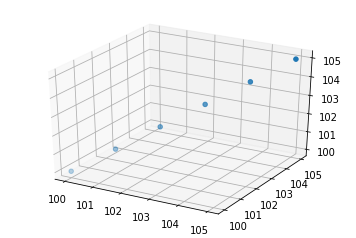

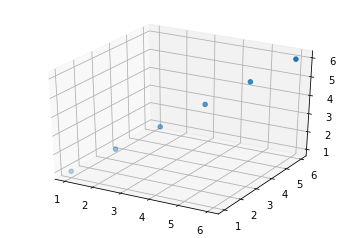

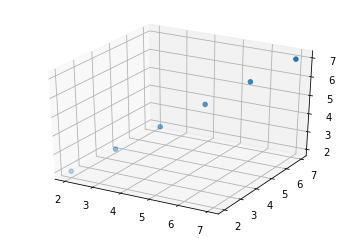

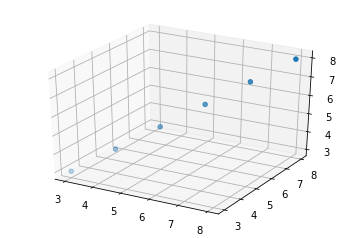

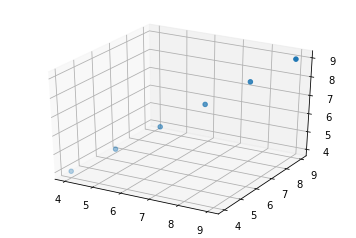

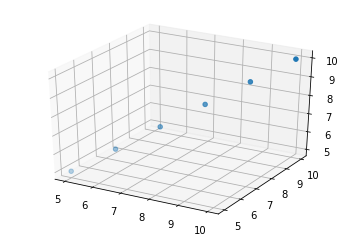

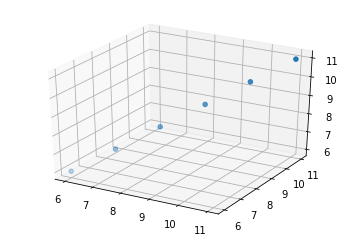

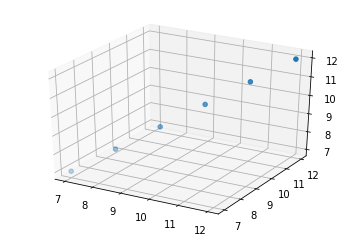

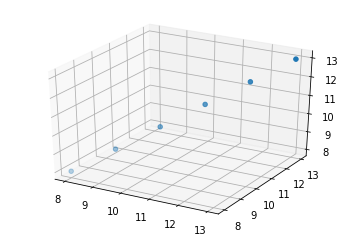

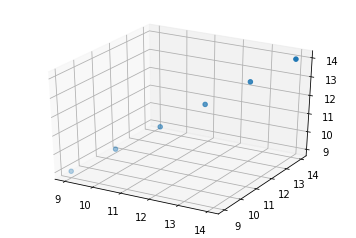

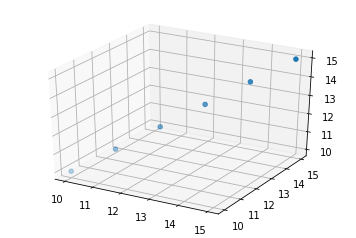

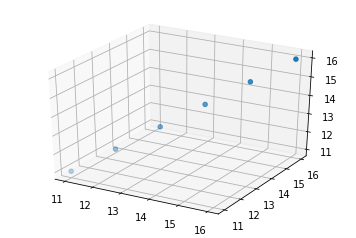

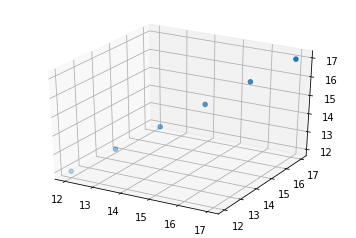

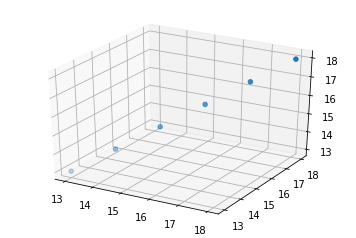

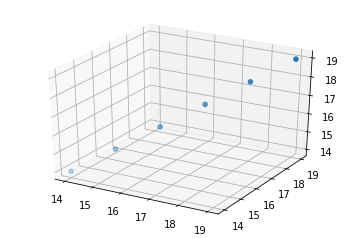

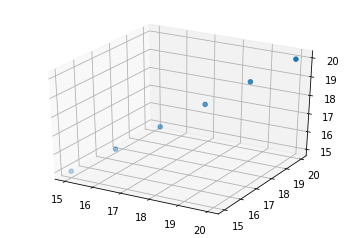

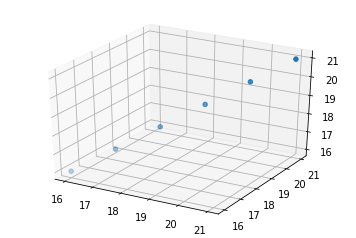

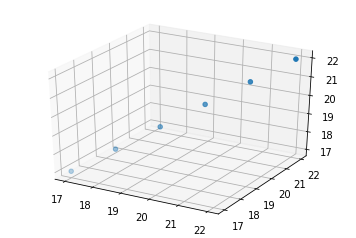

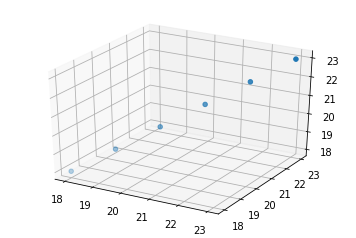

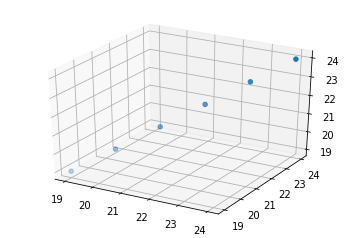

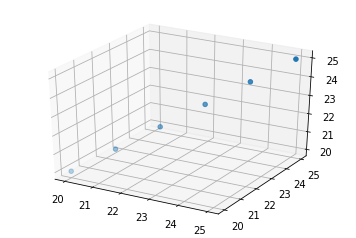

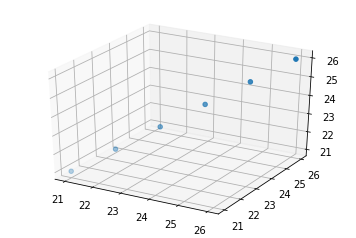

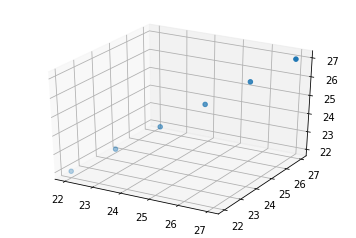

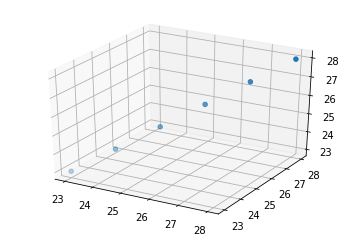

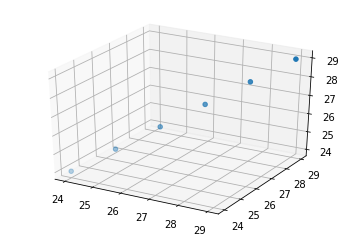

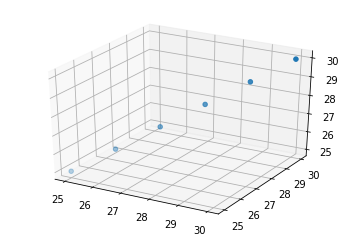

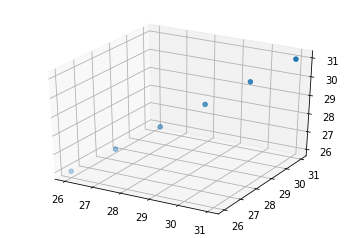

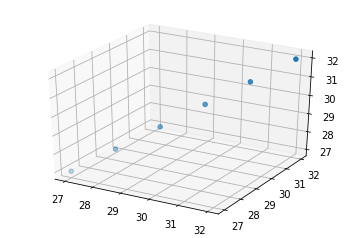

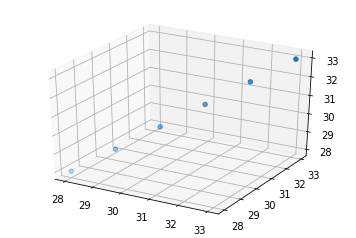

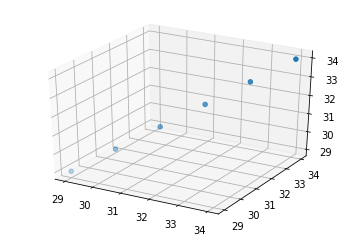

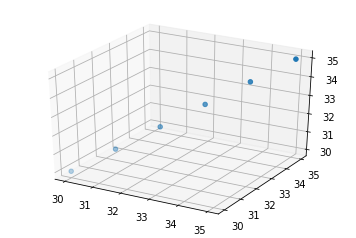

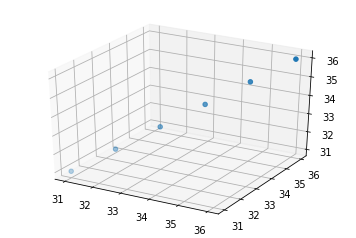

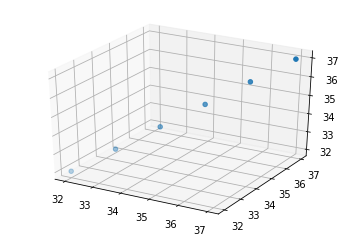

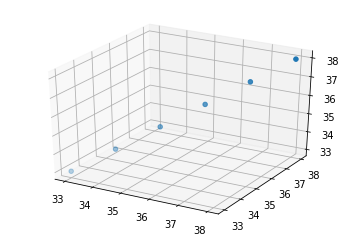

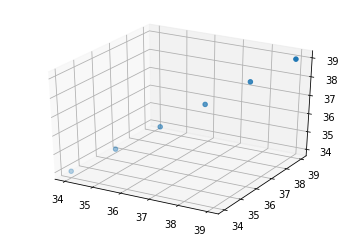

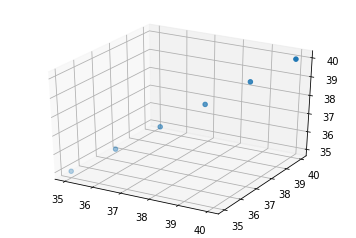

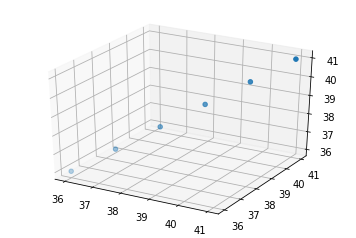

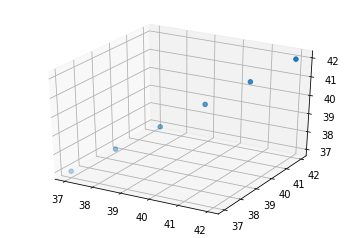

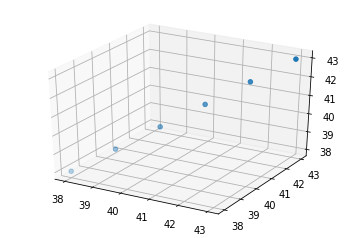

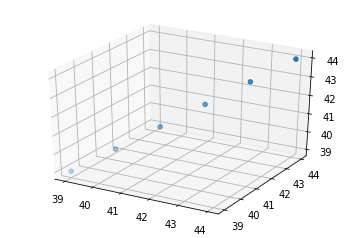

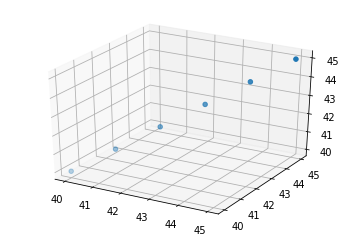

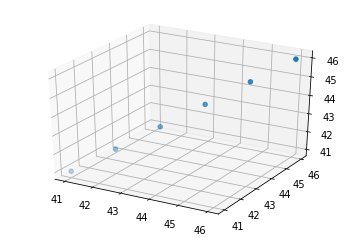

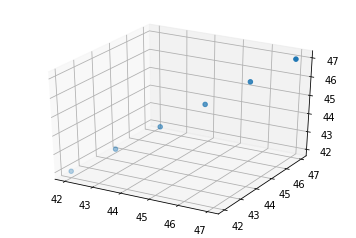

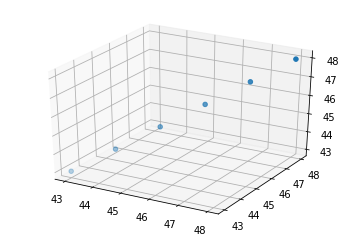

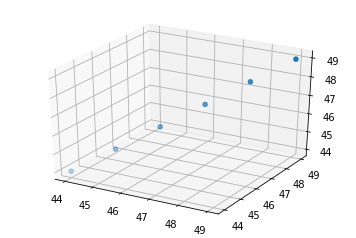

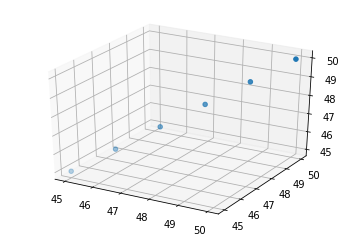

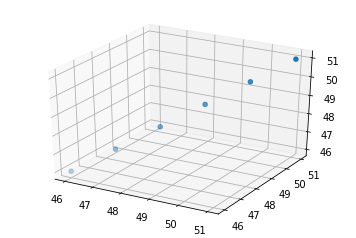

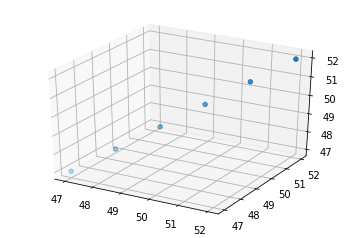

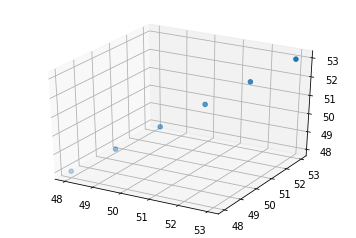

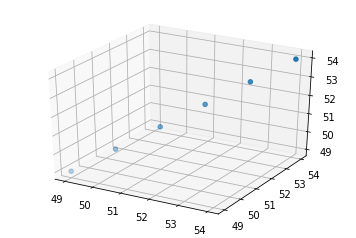

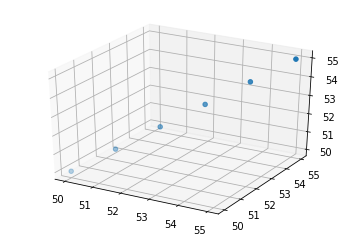

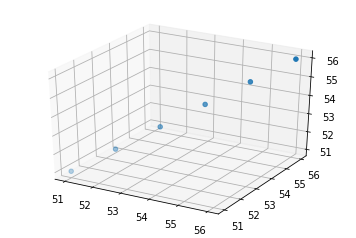

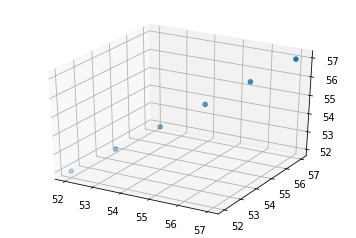

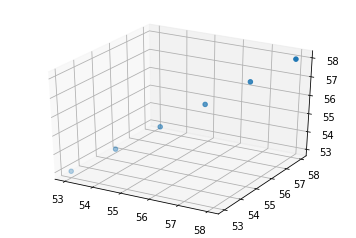

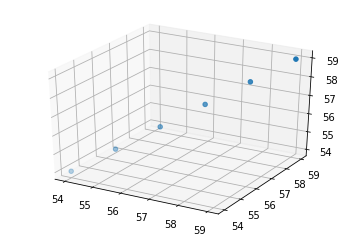

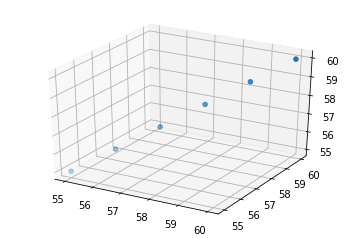

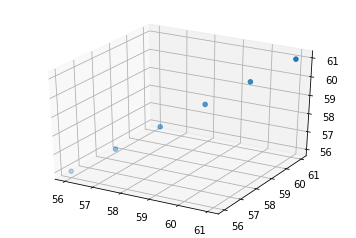

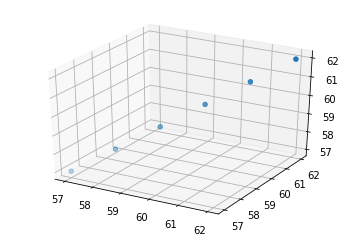

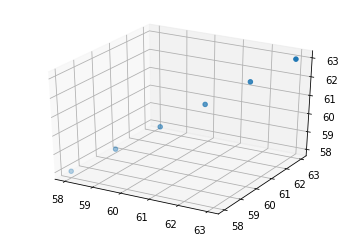

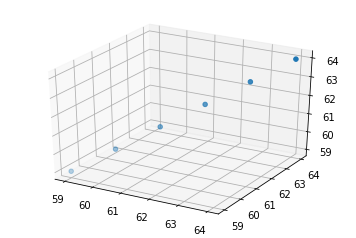

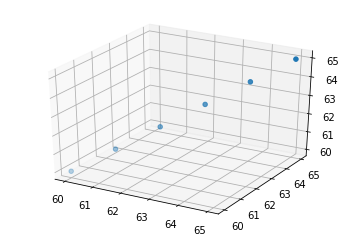

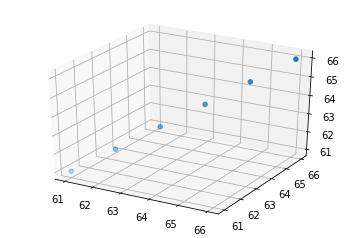

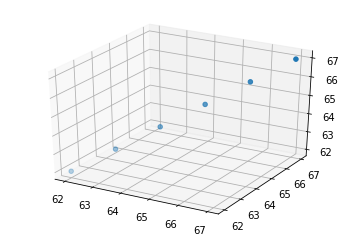

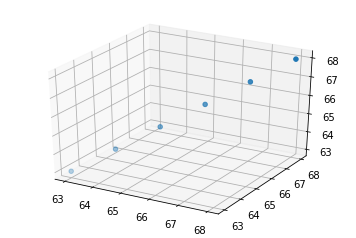

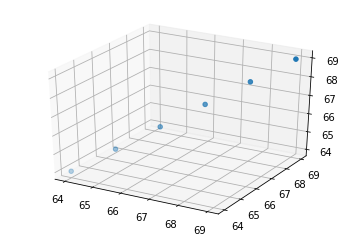

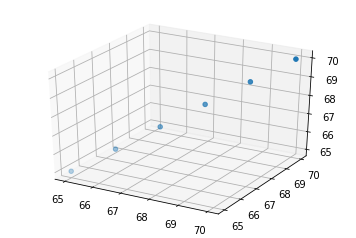

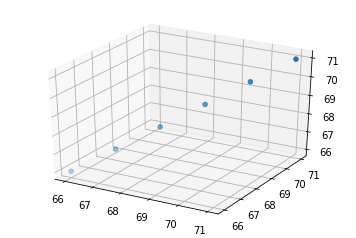

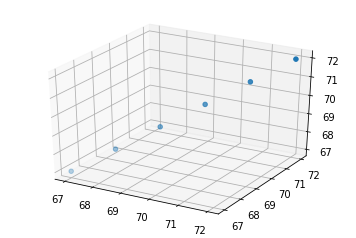

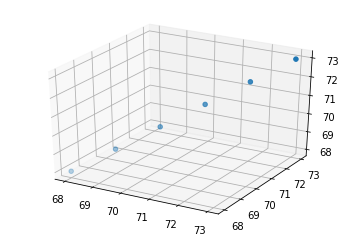

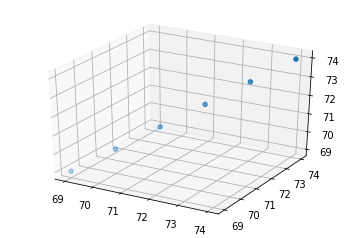

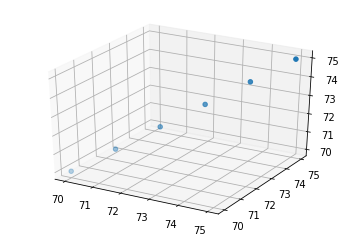

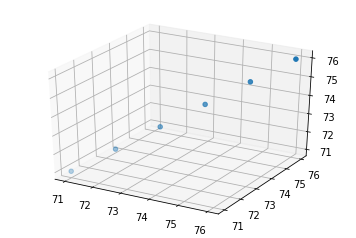

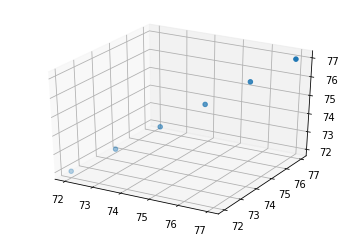

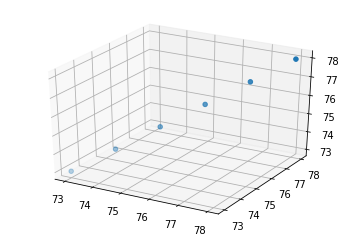

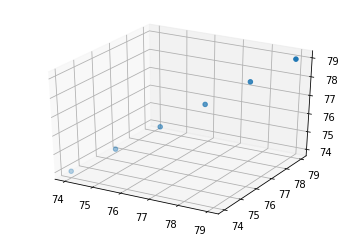

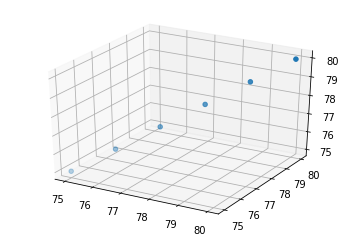

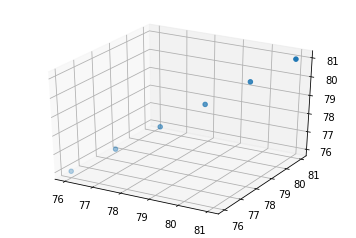

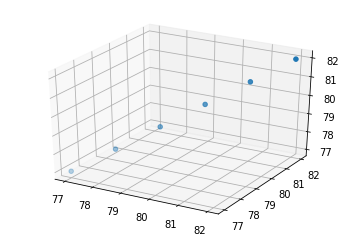

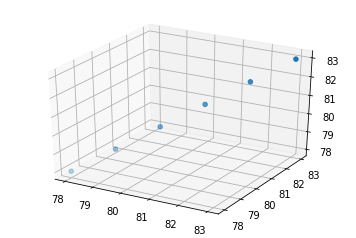

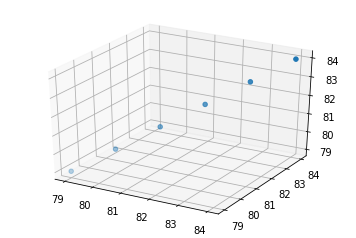

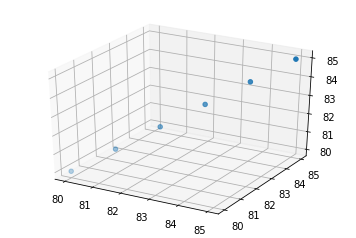

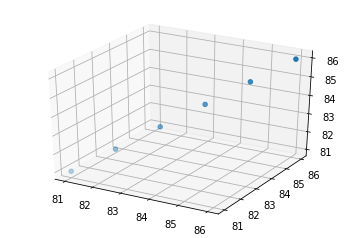

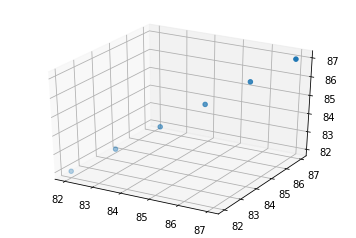

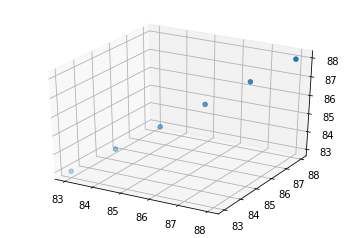

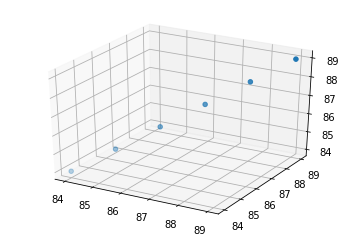

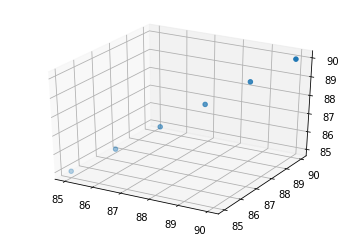

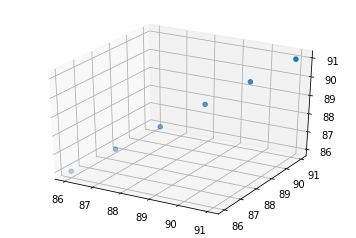

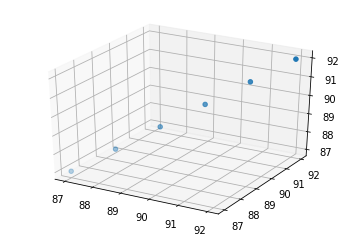

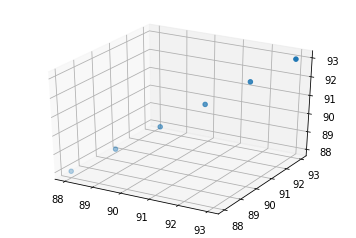

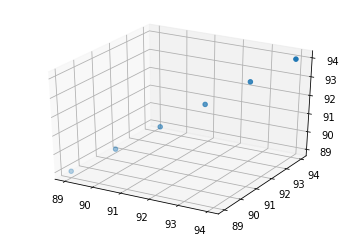

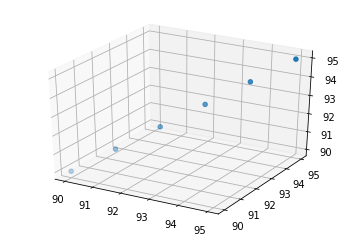

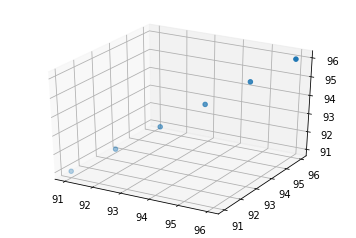

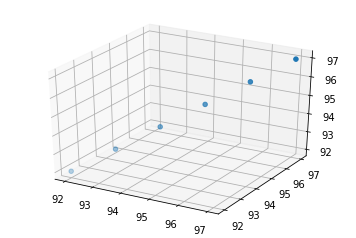

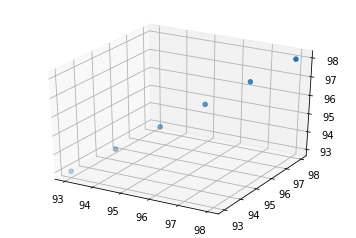

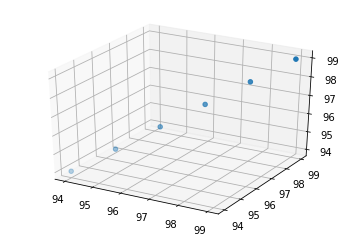

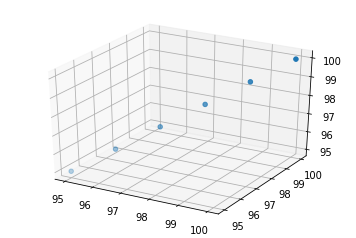

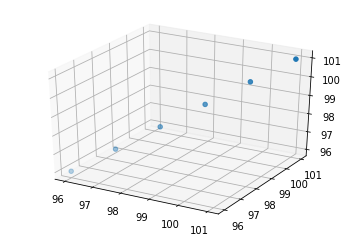

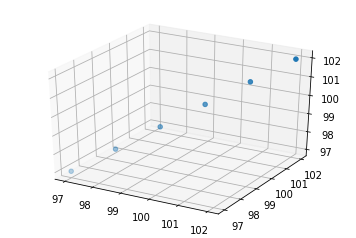

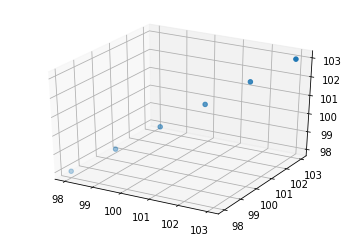

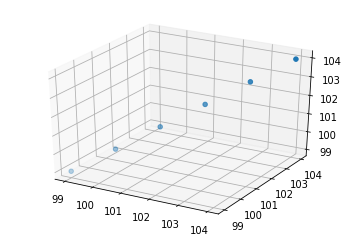

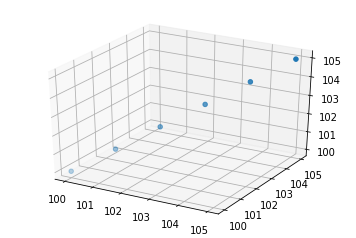

In [38]:
for i in range(100):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    xs = np.array([1,2,3,4,5,6])+ i
    ys = np.array([1,2,3,4,5,6])+ i
    zs = np.array([1,2,3,4,5,6])+ i
    ax.scatter(xs, ys, zs)
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(0.1)

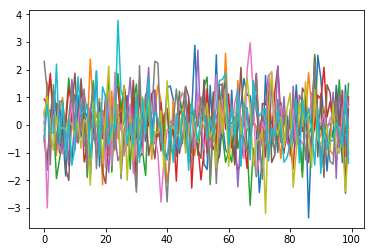

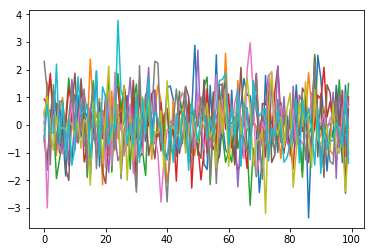

In [36]:
%matplotlib inline
import time
import pylab as pl
from IPython import display
for i in range(10):
    pl.plot(pl.randn(100))
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(1.0)

In [44]:
import cProfile
import hash

ModuleNotFoundError: No module named 'hash'

In [20]:
s = time.time()
print("dr")
time.time()-s

dr


0.00015687942504882812